<Figure size 1000x700 with 0 Axes>

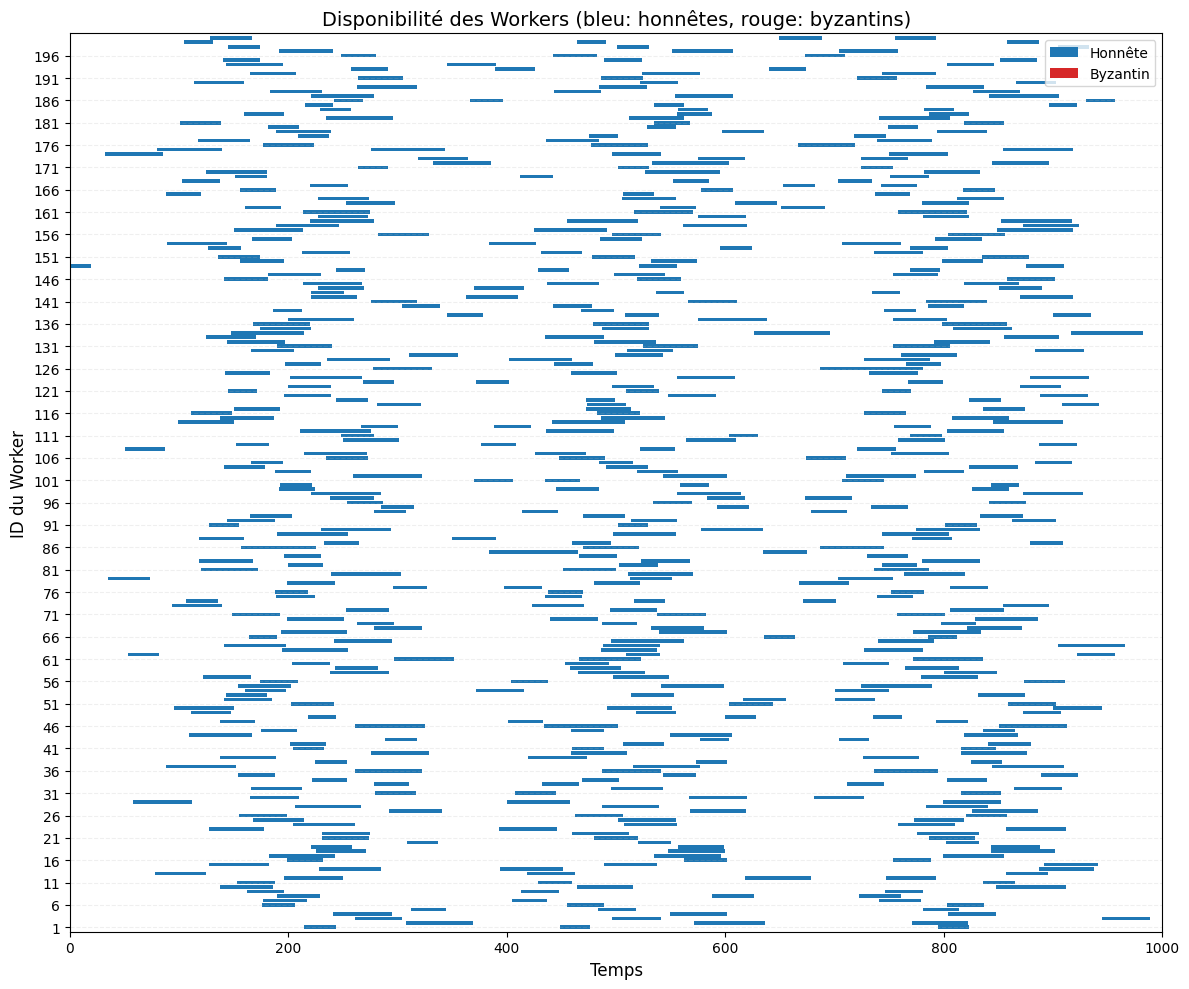

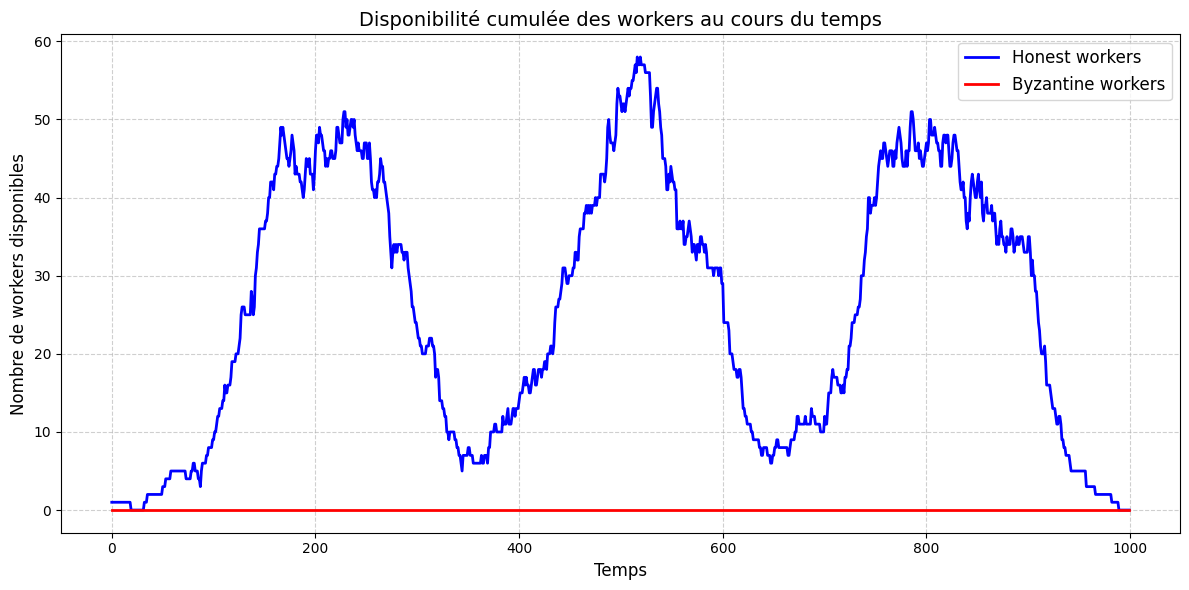

[t=56] Full batch 1 → acc 20.61%
[t=84] Full batch 2 → acc 10.24%
[t=108] Full batch 3 → acc 39.22%
[t=119] Full batch 4 → acc 54.45%
[t=126] Full batch 5 → acc 66.75%
[t=133] Full batch 6 → acc 71.28%
[t=140] Full batch 7 → acc 74.50%
[t=146] Full batch 8 → acc 73.14%
[t=155] Full batch 9 → acc 74.62%
[t=161] Full batch 10 → acc 82.40%
[t=169] Full batch 11 → acc 78.35%
[t=176] Full batch 12 → acc 86.98%
[t=182] Full batch 13 → acc 83.53%
[t=189] Full batch 14 → acc 83.95%
[t=195] Full batch 15 → acc 87.54%
[t=200] Full batch 16 → acc 90.04%
[t=206] Full batch 17 → acc 90.55%
[t=212] Full batch 18 → acc 90.43%
[t=218] Full batch 19 → acc 89.95%
[t=224] Full batch 20 → acc 90.12%
[t=230] Full batch 21 → acc 90.59%
[t=236] Full batch 22 → acc 91.99%
[t=242] Full batch 23 → acc 93.00%
[t=249] Full batch 24 → acc 93.35%
[t=255] Full batch 25 → acc 93.45%
[t=262] Full batch 26 → acc 93.65%
[t=268] Full batch 27 → acc 93.58%
[t=276] Full batch 28 → acc 93.65%
[t=284] Full batch 29 → acc 93.

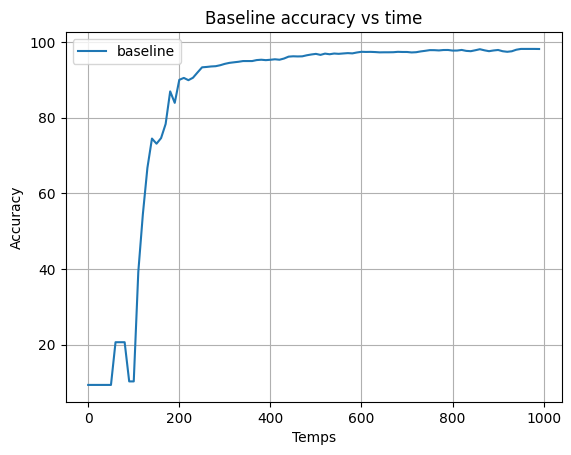


📊 Rapport de temps de calcul :
- Temps brut total : 3895
- Temps utile        : 0
- Temps gaspillé     : 0
- Taux de gaspillage : 0.00%


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision import datasets, transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import byzfl
import torch.nn.functional as F


# ------------------------------------------------------------------------------
# Fonctions utilitaires (inchangées)
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for curr in intervals[1:]:
        last = merged[-1]
        if curr[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], curr[1]))
        else:
            merged.append(curr)
    return merged

def generate_gaussian_availability(T, wid, n_workers,
                                   std_dev_ratio=0.065, min_pt=3,
                                   smooth=10):
    peaks = [0.2, 0.5, 0.8]
    sd = int(std_dev_ratio * T)
    periods = []
    for m in peaks:
        mu = int(m * T)
        start = int(np.random.normal(mu, sd))
        start = max(0, min(start, T - min_pt*3))
        dur = random.randint(min_pt*3, min(min_pt*5, T - start))
        periods.append((start, start + dur))
    merged = merge_intervals(periods)
    return merge_intervals([(max(0,s-smooth), min(T,e+smooth)) for s,e in merged])

def generate_gaussian_byzantine_availability(T, wid, n_workers,
                                             std_dev_ratio=0.04, min_pt=3,
                                             smooth=10):
    peaks = [0.06, 0.9]
    sd = int(std_dev_ratio * T)
    periods = []
    for m in peaks:
        mu = int(m * T)
        start = int(np.random.normal(mu, sd))
        start = max(0, min(start, T - min_pt*4))
        dur = random.randint(min_pt*4, min(min_pt*8, T - start))
        periods.append((start, start + dur))
    merged = merge_intervals(periods)
    return merge_intervals([(max(0,s-smooth), min(T,e+smooth)) for s,e in merged])


# ------------------------------------------------------------------------------
# Modèle
class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Gestionnaire de batch
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Workers
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.is_byzantine = False
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None
    def is_available(self, current_time):
        for start, end in self.availability_periods:
            if start <= current_time < end and (self.finish_time is None or current_time >= self.finish_time):
                return (current_time + self.processing_time) <= end
        return False
    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            return self.compute_gradient(data, targets)
        return None
    def has_finished(self, current_time):
        return self.finish_time == current_time
    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        gradients = {name: param.grad.detach().clone() for name, param in self.model.named_parameters()}
        return gradients, self.current_batch_info
    def update_model(self, model_state_dict):
        self.model.load_state_dict(model_state_dict)

class ByzantineWorker(Worker):
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        super().__init__(model, device, worker_id, availability_periods, processing_time)
        self.is_byzantine = True
    def compute_gradient(self, data, targets):
        corrupted = {name: torch.full_like(param, 1e6) for name, param in self.model.named_parameters()}
        return corrupted, self.current_batch_info

# ------------------------------------------------------------------------------
# Server sans logique de vote
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005, verbose=False,
                 aggregation_strategy='trimmed_mean', f=0, preagg=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_batch_id = 0
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.f = f
        self.preagg = preagg
        self.total_raw_compute_time = 0
        self.total_useful_compute_time = 0
        self.total_waste_compute_time = 0
        self.current_full_batch_compute_time = 0

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_batch_id += 1
        self.current_full_batch_compute_time = 0
        num = data.size(0)
        minibatches = [(data[i:i+self.mini_batch_size], targets[i:i+self.mini_batch_size])
                      for i in range(0, num, self.mini_batch_size)]
        self.current_mini_batches = {i: minibatches[i] for i in range(len(minibatches))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[Temps {current_time}] Full batch {self.current_batch_id} préparé avec {len(minibatches)} mini-batches.")

    def register_gradient(self, gradients, batch_info, worker_id, current_time, worker_processing_time, is_byzantine=False):
        bid, mid = batch_info
        if bid != self.current_batch_id or mid in self.received_gradients:
            return
        self.total_raw_compute_time += worker_processing_time
        self.current_full_batch_compute_time += worker_processing_time
        self.received_gradients[mid] = gradients
        if self.verbose:
            tag = " (Byzantin)" if is_byzantine else ""
            print(f"[Temps {current_time}] Gradient reçu pour mini-batch {mid} par worker {worker_id}{tag} (tps: {worker_processing_time}).")

    def aggregate_and_update(self):
        if len(self.received_gradients) != len(self.current_mini_batches):
            if self.verbose:
                print("Attention : certains mini-batches ne sont pas traités.")
            return False
        pre = None
        if self.preagg == "NNM":
            pre = byzfl.NNM(f=self.f)
        elif self.preagg == "Bucketing":
            pre = byzfl.Bucketing(s=1)
        elif self.preagg == "ARC":
            pre = byzfl.ARC(f=self.f)
        aggs = {}
        for name, param in self.model.named_parameters():
            grads = [self.received_gradients[i][name] for i in self.current_mini_batches]
            G = torch.stack(grads).view(len(grads), -1)
            if pre:
                try:
                    G = pre(G)
                except Exception as e:
                    print(f"Pré-agg {self.preagg} error: {e}")
            if self.aggregation_strategy == "trimmed_mean":
                agg_flat = byzfl.TrMean(f=max(self.f,(len(grads)//2)-1))(G)
            elif self.aggregation_strategy == "average":
                agg_flat = byzfl.Average()(G)
            else:
                raise ValueError(f"Stratégie inconnue: {self.aggregation_strategy}")
            aggs[name] = agg_flat.view(param.size())
        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = aggs[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Modèle mis à jour avec le full batch {self.current_batch_id}.")
        return True

    def evaluate(self, test_loader):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for d, t in test_loader:
                d, t = d.to(self.device), t.to(self.device)
                out = self.model(d); pred = out.argmax(dim=1)
                total += t.size(0); correct += (pred==t).sum().item()
        return 100 * correct / total

    def report_compute_metrics(self):
        total = self.total_raw_compute_time
        useful = self.total_useful_compute_time
        waste = self.total_waste_compute_time
        rate = 100*waste/total if total else 0
        print("\n📊 Rapport de temps de calcul :")
        print(f"- Temps brut total : {total}")
        print(f"- Temps utile        : {useful}")
        print(f"- Temps gaspillé     : {waste}")
        print(f"- Taux de gaspillage : {rate:.2f}%")
        

    def advance_decision(self, p1, p2, p3, sp):
        if p1 == p2 == p3:
            return "rollback"
        conds = [
            p1>sp and p2>p1 and p3>sp,
            p1>sp and p2<=p1 and p3>p1,
            p1<=sp and p2>sp and p3>p2,
            p1<=sp and p2>p1 and p2>sp and p3<p2 and p3>sp,
            p1<=sp and p2<=p1 and p3>sp
        ]
        return "accept" if any(conds) else "rollback"

# ------------------------------------------------------------------------------
def create_workers(num_worker, byzantine_indices_cycle, steps_per_cycle, server):
    workers = []
    for i in range(1, num_worker+1):
        pt = random.randint(2,10)
        if i in byzantine_indices_cycle:
            av = generate_gaussian_byzantine_availability(steps_per_cycle, i, num_worker, min_pt=pt)
            workers.append(ByzantineWorker(server.model, server.device, i, av, pt))
        else:
            av = generate_gaussian_availability(steps_per_cycle, i, num_worker, min_pt=pt)
            workers.append(Worker(server.model, server.device, i, av, pt))
    return workers

# ------------------------------------------------------------------------------
class BaseLineSimulator:
    def __init__(self, server, workers, test_loader, total_time_steps=1000):
        self.server = server
        self.workers = workers
        self.test_loader = test_loader
        self.total_time_steps = total_time_steps
        self.global_time = 0
        self.in_progress = []               # workers en cours
        self.server.get_new_complete_batch(0)
        self.plot_worker_availability()


    def run(self, verbose=False, eval_interval=10):
        time_points = []
        accuracies = []

        while self.global_time < self.total_time_steps:
            # 1) collecter les travailleurs terminés
            done = [w for w in self.in_progress if w.has_finished(self.global_time)]
            for w in done:
                grads, batch_info = w.compute_gradient(
                    *self.server.current_mini_batches[w.current_batch_info[1]]
                )
                # on enregistre un seul gradient par mini-batch
                self.server.register_gradient(grads,
                                              w.current_batch_info,
                                              w.worker_id,
                                              self.global_time,
                                              w.processing_time,
                                              w.is_byzantine)
                self.in_progress.remove(w)
                w.current_batch_info = None
                
            # 2) si tous les mini-batches sont arrivés → agrégation & MAJ
            if len(self.server.received_gradients) == len(self.server.current_mini_batches):
                self.server.aggregate_and_update()
                acc = self.server.evaluate(self.test_loader)
                if verbose:
                    print(f"[t={self.global_time}] Full batch {self.server.current_batch_id} → acc {acc:.2f}%")
                # préparation du batch suivant
                self.server.get_new_complete_batch(self.global_time)
                self.in_progress.clear()

            # 3) assigner tous les mini-batches restants à K=1 worker chacun
            avail = [w for w in self.workers
                     if w.is_available(self.global_time) and w not in self.in_progress]
            for mi in sorted(self.server.current_mini_batches):
                if mi not in self.server.received_gradients and avail:
                    w = avail.pop(0)
                    w.update_model(self.server.model.state_dict())
                    data, tgt = self.server.current_mini_batches[mi]
                    w.start_computation(self.global_time,
                                        (self.server.current_batch_id, mi),
                                        data, tgt)
                    self.in_progress.append(w)
                    
            # 4) logging périodique
            if self.global_time % eval_interval == 0:
                curr = self.server.evaluate(self.test_loader)
                time_points.append(self.global_time)
                accuracies.append(curr)

            self.global_time += 1

        # Fin de simulation
        final_acc = self.server.evaluate(self.test_loader)
        print(f"### Baseline final accuracy: {final_acc:.2f}%")
        # tracer l'évolution
        plt.plot(time_points, accuracies, label="baseline")
        plt.xlabel("Temps"); plt.ylabel("Accuracy"); plt.title("Baseline accuracy vs time")
        plt.grid(True); plt.legend(); plt.show()
        return time_points, accuracies,final_acc

    def plot_worker_availability(self):
        """
        Affiche, pour chaque instant de temps, le nombre total de workers honnêtes (bleu)
        et Byzantins (rouge) disponibles.
        """

        num_workers = len(self.workers)
        fig_height = max(6, min(0.05 * num_workers, 20))
        fig, ax = plt.subplots(figsize=(12, fig_height))
        for worker in self.workers:
            color = "tab:red" if isinstance(worker, ByzantineWorker) else "tab:blue"
            for (start, end) in worker.availability_periods:
                ax.broken_barh([(start, end - start)], (worker.worker_id - 0.4, 0.8), facecolors=color)
        ax.set_xlabel("Temps", fontsize=12)
        ax.set_ylabel("ID du Worker", fontsize=12)
        ax.set_title("Disponibilité des Workers (bleu: honnêtes, rouge: byzantins)", fontsize=14)
        ax.set_xlim(0, self.total_time_steps)
        max_worker_id = max(worker.worker_id for worker in self.workers)
        ax.set_ylim(0, max_worker_id + 1)
        step = max(1, num_workers // 40)
        ax.set_yticks(list(range(1, max_worker_id + 1, step)))
        ax.grid(True, axis='y', linestyle='--', alpha=0.2)
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='tab:blue', label='Honnête'),
            Patch(facecolor='tab:red', label='Byzantin')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        plt.show()


        # Initialiser deux tableaux pour compter séparément
        avail_honest = [0] * self.total_time_steps
        avail_byz   = [0] * self.total_time_steps

        for worker in self.workers:
            target = avail_byz if worker.is_byzantine else avail_honest
            for start, end in worker.availability_periods:
                for t in range(start, min(end, self.total_time_steps)):
                    target[t] += 1

        times = range(self.total_time_steps)
        plt.figure(figsize=(12, 6))
        plt.plot(times, avail_honest, label="Honest workers", color="blue", linewidth=2)
        plt.plot(times, avail_byz,   label="Byzantine workers", color="red",  linewidth=2)
        plt.xlabel("Temps", fontsize=12)
        plt.ylabel("Nombre de workers disponibles", fontsize=12)
        plt.title("Disponibilité cumulée des workers au cours du temps", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    
# ------------------------------------------------------------------------------
def run_experiment(num_cycles=2, num_runs=1, steps_per_cycle=1000, byzantine_ratio=0.0,
                   aggregation_strategy='trimmed_mean', preagg=None):
    num_worker = 200
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=trans)
    test_ds  = datasets.MNIST('./data', train=False, download=True, transform=trans)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    for _ in range(num_runs):
        server = Server(train_ds, batch_size=360, mini_batch_size=36,
                        verbose=False, aggregation_strategy=aggregation_strategy, preagg=preagg)
        for _ in range(num_cycles):
            byz = set(random.sample(range(1, num_worker+1), int(num_worker * byzantine_ratio)))
            workers = create_workers(num_worker, byz, steps_per_cycle, server)
            sim = BaseLineSimulator(server, workers, test_loader, total_time_steps=steps_per_cycle)
            tmps, acc_over_time, acc= sim.run(verbose=True, eval_interval=10)
            server.report_compute_metrics()
        #results.append(server.evaluate(test_loader))
    return tmps, acc_over_time, acc

# ------------------------------------------------------------------------------
preagg_methods      = [None]
aggregator_methods  = ["average"]
byzantine_ratios    = [0.0]
num_runs            = 1
num_cycles          = 1
steps_per_cycle     = 1000


results = {}
final_accuracies = {}
tps = None
for preagg in preagg_methods:
    plt.figure(figsize=(10,7))
    for agg in aggregator_methods:
        for ratio in byzantine_ratios:
            tps, acc_bl, final_acc = run_experiment(num_cycles=num_cycles,
                                    num_runs=num_runs,
                                    steps_per_cycle=steps_per_cycle,
                                    byzantine_ratio=ratio,
                                    aggregation_strategy=agg,
                                    preagg=preagg)
            
results["baseline"] = (tps, acc_bl)
final_accuracies["baseline"] = final_acc

# plt.figure(figsize=(10, 6))
# for ratio, (time_points, acc_over_time) in trajectories.items():
#     plt.plot(time_points,acc_over_time,linewidth=2,markersize=5,label=f"{int(ratio*100)}% Byzantins")
# plt.plot(tps, acc_bl,markersize=5,label=f"Pure Computing")
# plt.xlabel("Temps", fontsize=14)
# plt.ylabel("Accuracy (%)", fontsize=14)
# plt.title("Évolution de l'accuracy au cours du temps", fontsize=16)
# plt.legend(title="Taux de Byzantins", fontsize=12, title_fontsize=13)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()
            



--- Simulation avec 0% de workers byzantins ---


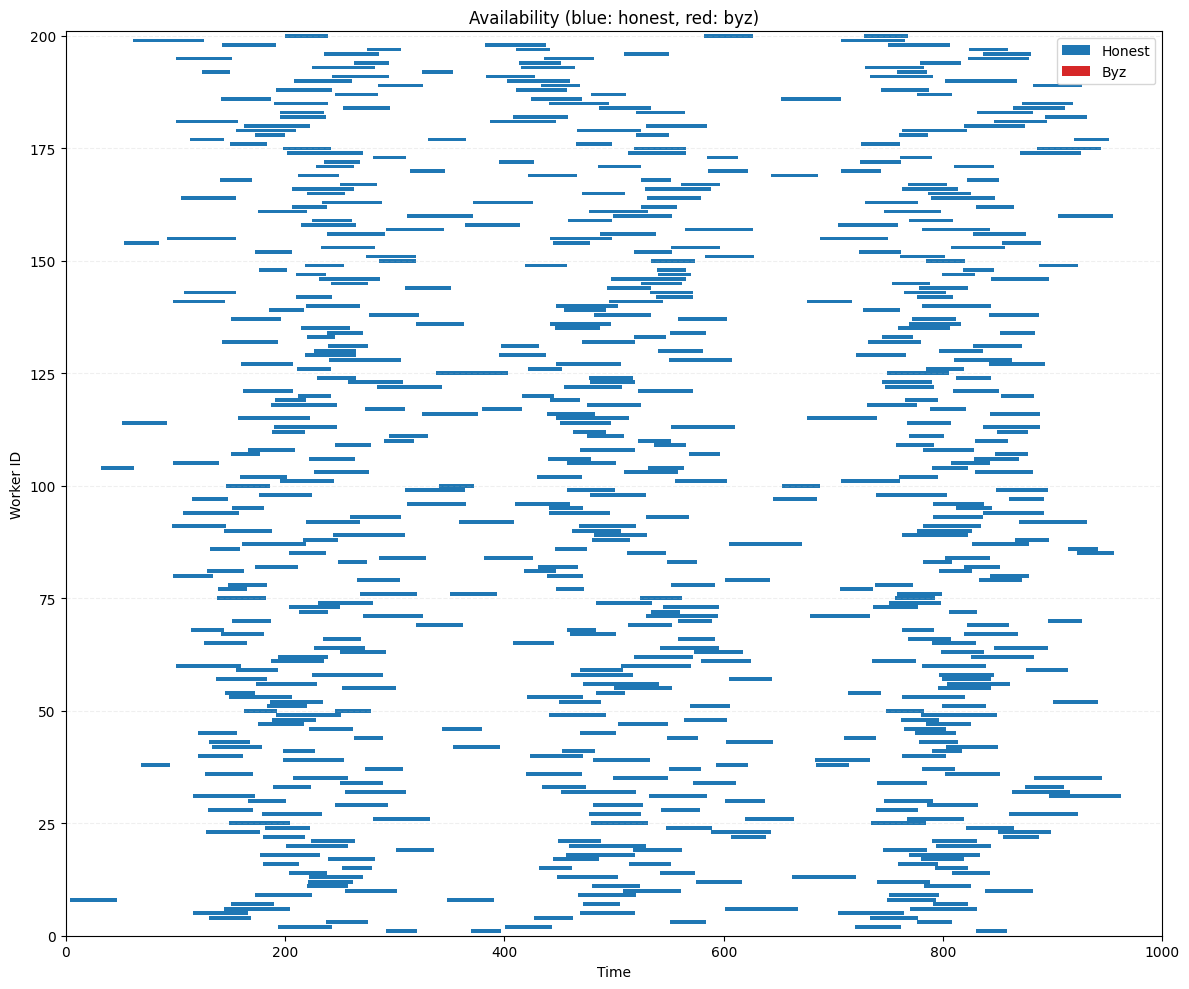

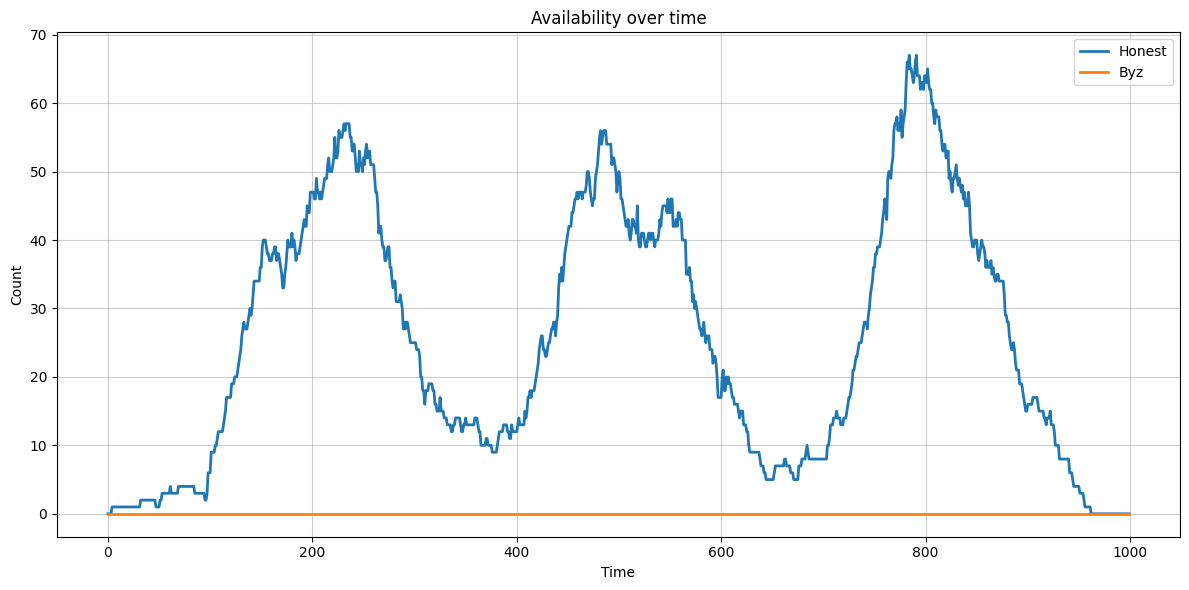

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 8.67%
[t=47] Cycle 1, batch #1 → Acc val: 14.68%
[t=77] Cycle 1, batch #2 → Acc val: 30.52%
[t=103] Cycle 1, batch #3 → Acc val: 22.67%
[t=122] Cycle 1, batch #4 → Acc val: 29.93%
[t=131] Cycle 1, batch #5 → Acc val: 42.16%
[t=137] Cycle 1, batch #6 → Acc val: 47.23%
[t=137] = Base rollback pour cycle 2 mise à jour
[t=137] New safe-point léger cycle 1 — Acc: 47.23% & slope>0
[t=143] Cycle 2, batch #1 → Acc val: 61.34%
[t=150] Cycle 2, batch #2 → Acc val: 70.77%
[t=157] Cycle 2, batch #3 → Acc val: 77.42%
[t=163] Cycle 2, batch #4 → Acc val: 78.40%
[t=170] Cycle 2, batch #5 → Acc val: 80.23%
[t=177] Cycle 2, batch #6 → Acc val: 83.66%
[t=177] New safe-point léger cycle 2 — Acc: 83.66% & slope>0
[t=177] Global slope: 6.7611, Slopes per cycle: {1: np.float64(5.855555555555554), 2: np.float64(4.026666666666666)}
Useful batches from cycle 1: [1, 2, 3, 4, 5, 6]
Useful batches from cycle 2: [7, 8, 9, 10, 11, 12]
[t=184] Cycle 1, batch #1 → Acc val: 85.

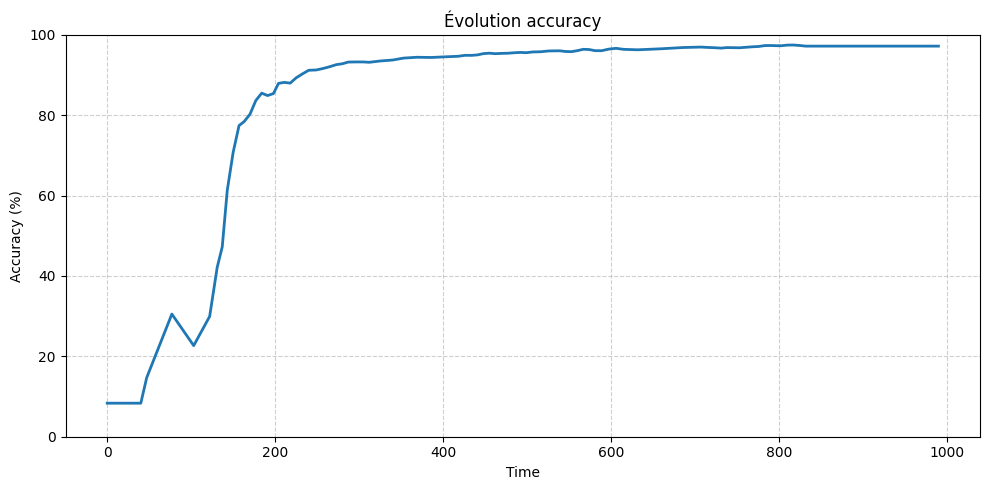

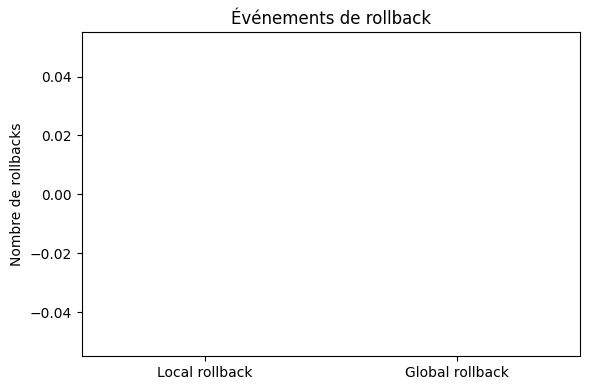

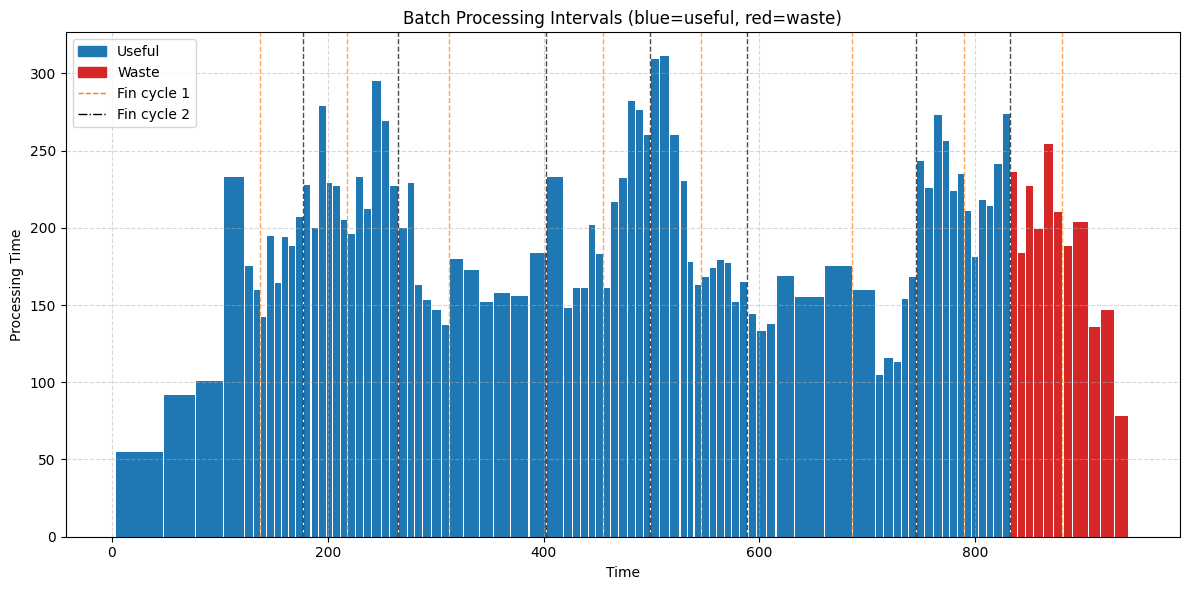

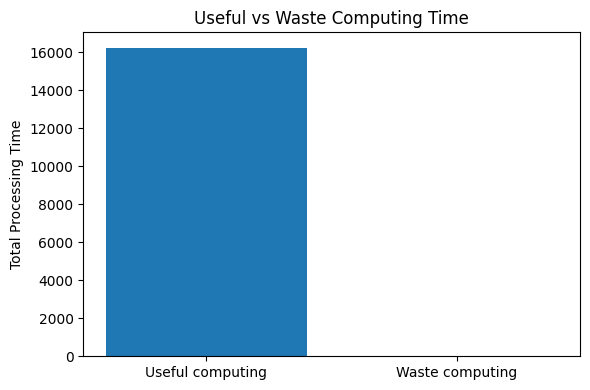

Total useful computing time: 16246
Total waste computing time: 0
Ratio useful/(useful+waste): 100.00%


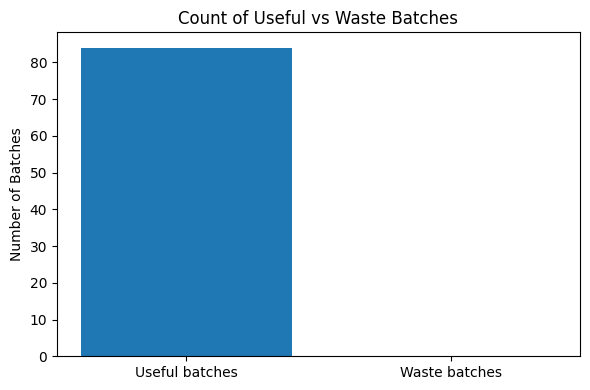

Total useful batches: 84
Total waste batches: 0
Ratio useful/(useful+waste): 100.00%
105
105
✔️ Honest worker coverage: 167/200 → 83.50%

--- Simulation avec 5% de workers byzantins ---


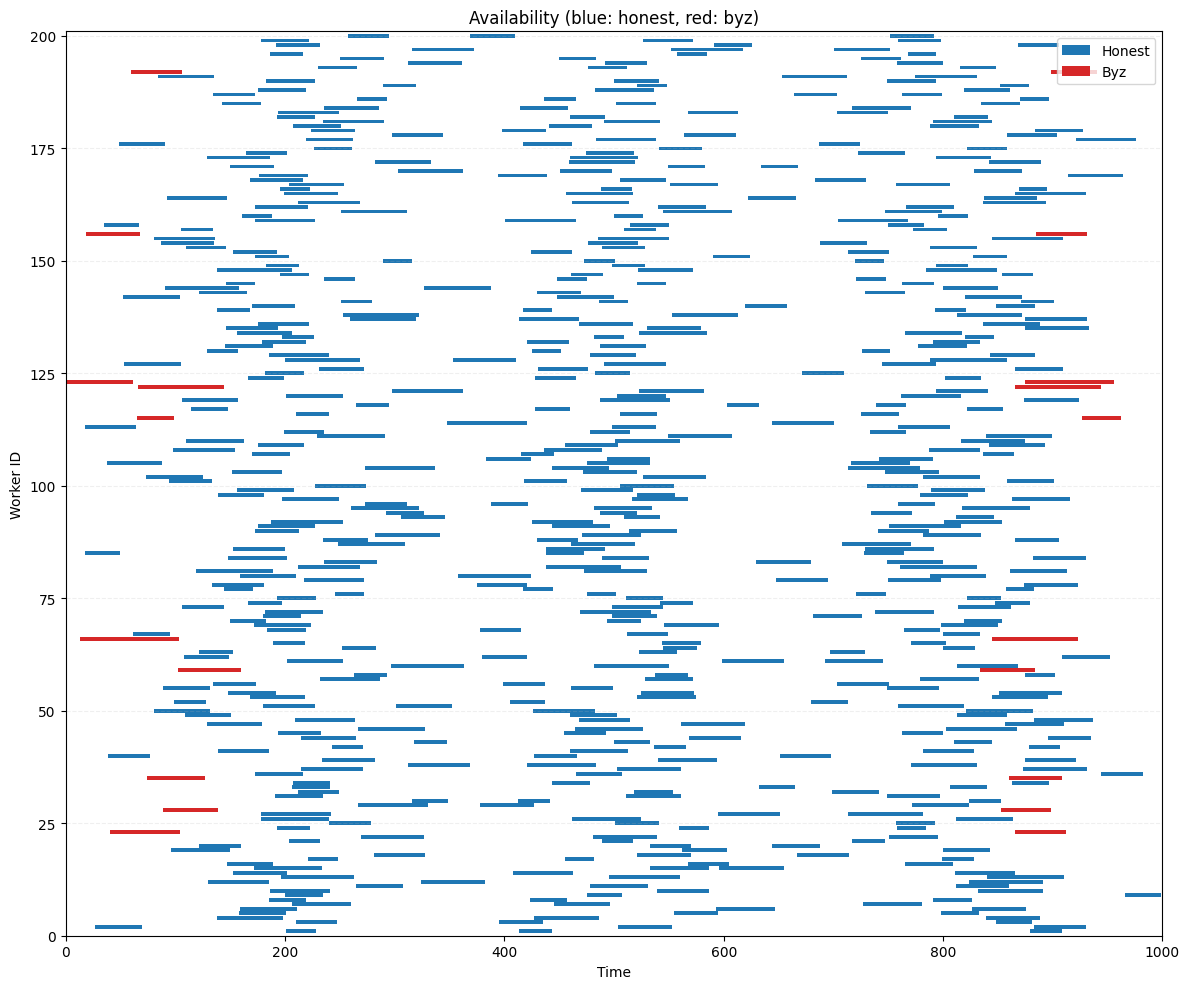

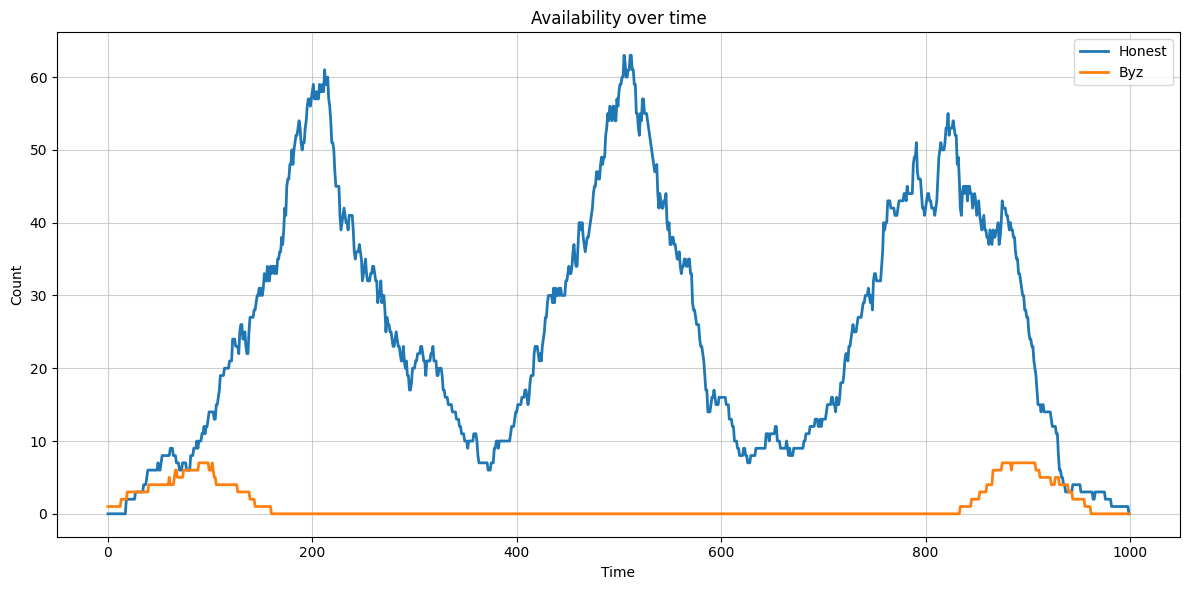

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 11.54%
[t=39] Cycle 1, batch #1 → Acc val: 9.20%
[t=52] Cycle 1, batch #2 → Acc val: 9.20%
[t=68] Cycle 1, batch #3 → Acc val: 9.20%
[t=81] Cycle 1, batch #4 → Acc val: 9.20%
[t=94] Cycle 1, batch #5 → Acc val: 9.20%
[t=105] Cycle 1, batch #6 → Acc val: 9.20%
[t=105] = Base rollback pour cycle 2 mise à jour
[t=105] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=105] Reset after rollback to majority
[t=157] Cycle 1, batch #1 → Acc val: 9.62%
[t=183] Cycle 1, batch #2 → Acc val: 34.88%
[t=201] Cycle 1, batch #3 → Acc val: 43.98%
[t=214] Cycle 1, batch #4 → Acc val: 53.06%
[t=230] Cycle 1, batch #5 → Acc val: 57.04%
[t=255] Cycle 1, batch #6 → Acc val: 63.18%
[t=255] = Base rollback pour cycle 2 mise à jour
[t=255] New safe-point léger cycle 1 — Acc: 63.18% & slope>0
[t=263] Cycle 2, batch #1 → Acc val: 66.14%
[t=270] Cycle 2, batch #2 → Acc val: 73.29%
[t=277] Cycle 2, batch #3 → Acc val: 73.61%
[t=286] Cycle 2, batc

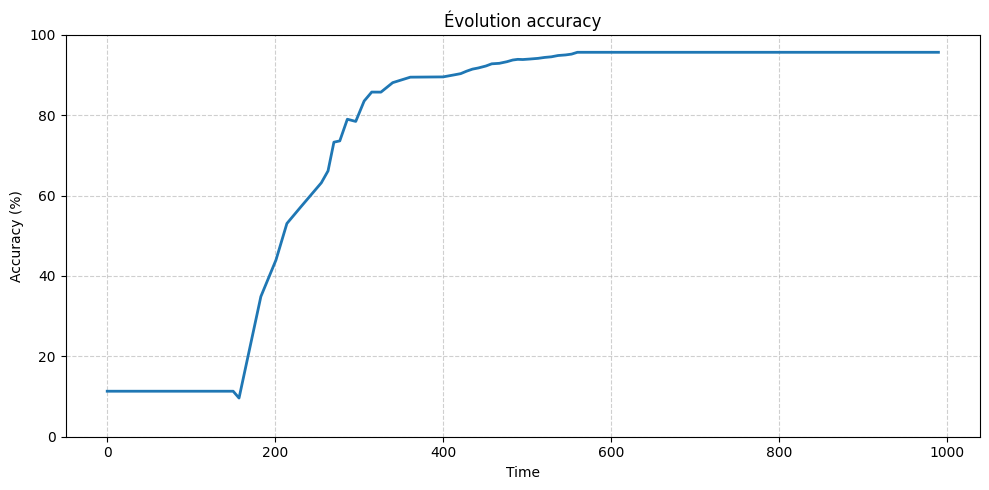

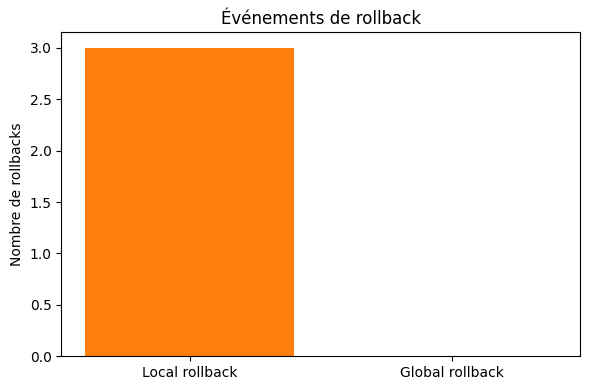

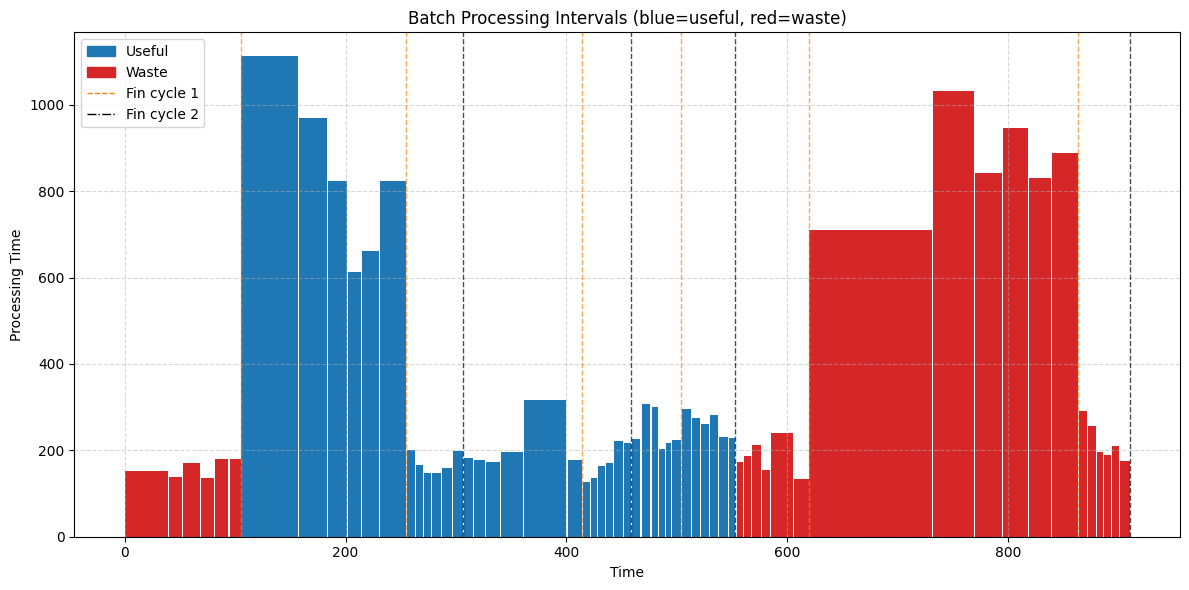

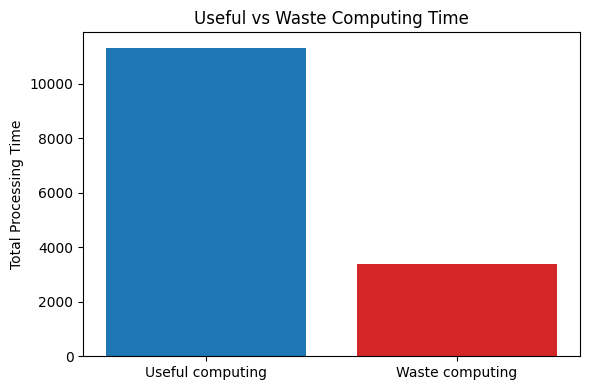

Total useful computing time: 11330
Total waste computing time: 3379
Ratio useful/(useful+waste): 77.03%


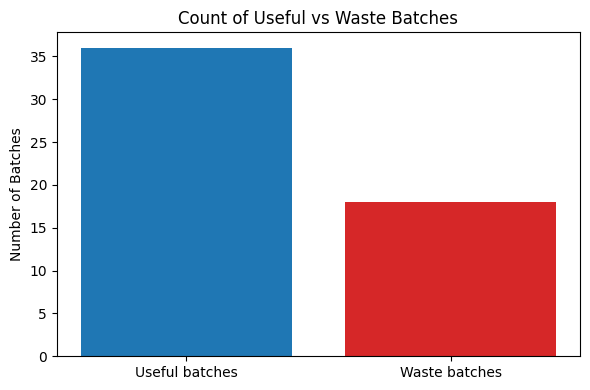

Total useful batches: 36
Total waste batches: 18
Ratio useful/(useful+waste): 66.67%
96
96
✔️ Honest worker coverage: 183/190 → 96.32%

--- Simulation avec 10% de workers byzantins ---


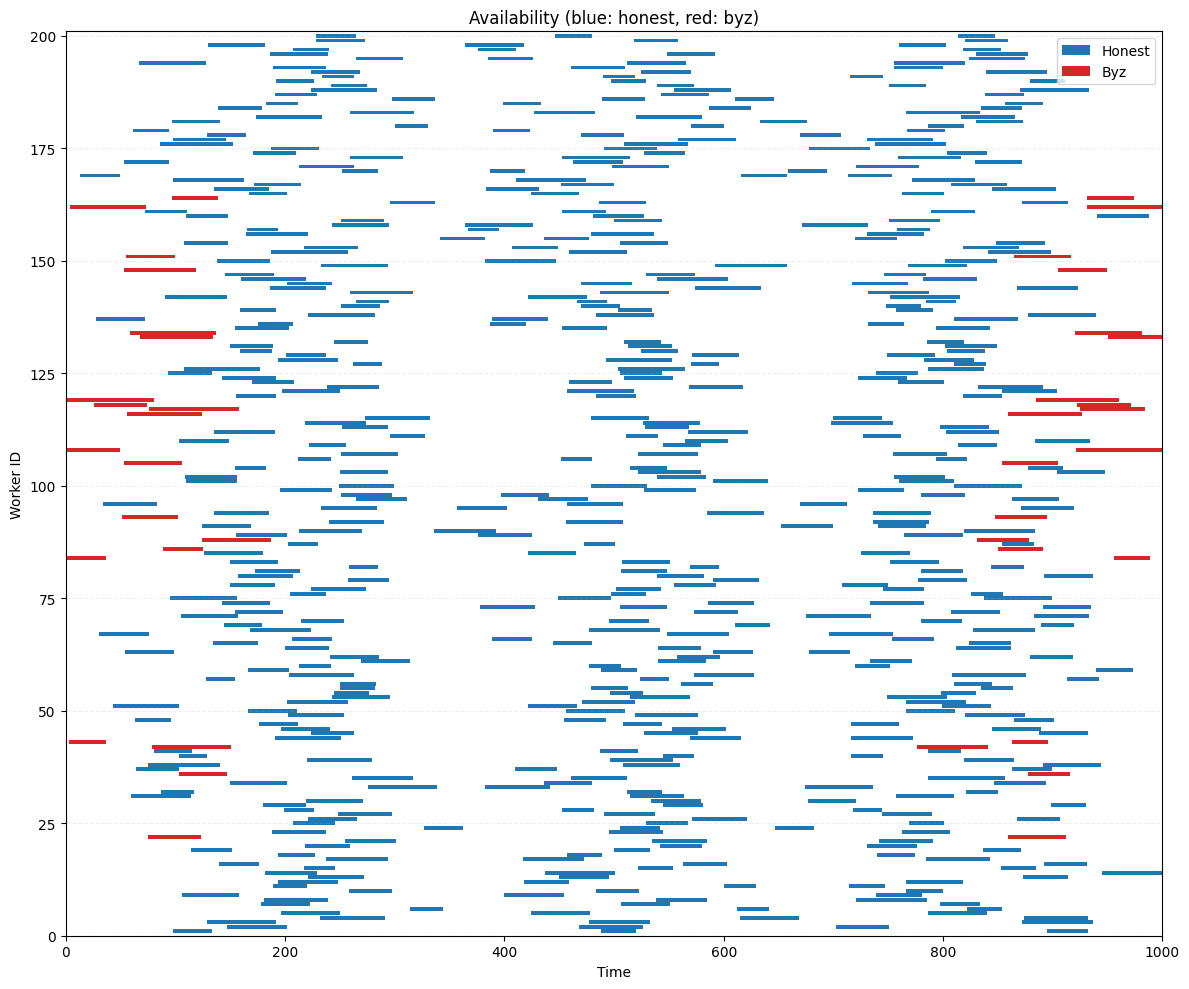

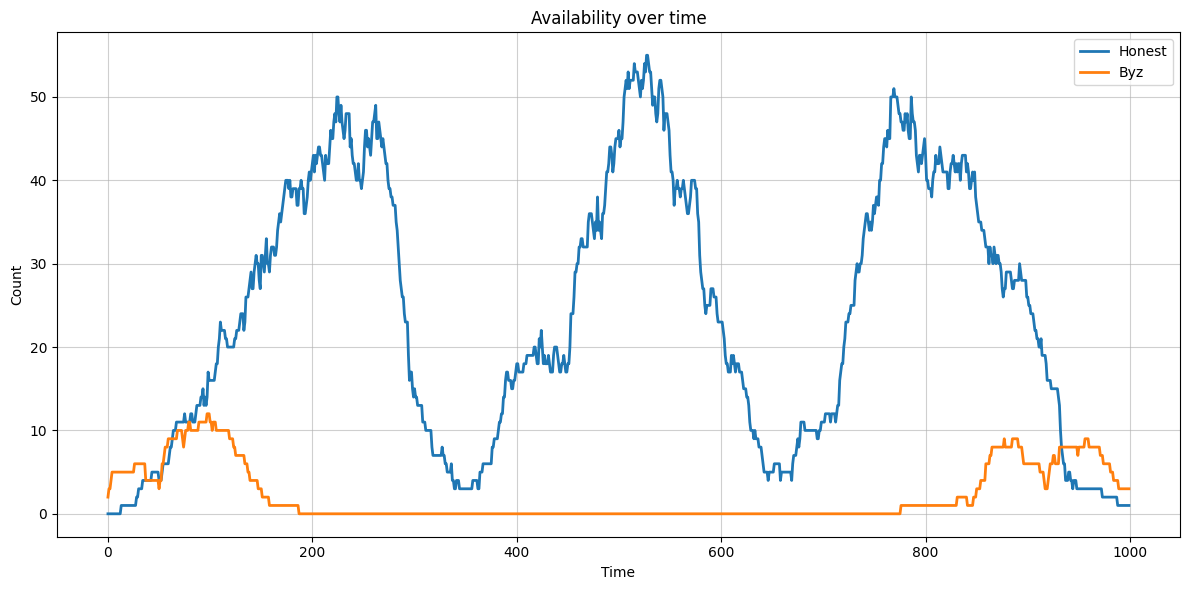

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 11.29%
[t=22] Cycle 1, batch #1 → Acc val: 10.63%
[t=44] Cycle 1, batch #2 → Acc val: 10.63%
[t=65] Cycle 1, batch #3 → Acc val: 10.63%
[t=77] Cycle 1, batch #4 → Acc val: 10.63%
[t=87] Cycle 1, batch #5 → Acc val: 10.63%
[t=97] Cycle 1, batch #6 → Acc val: 10.63%
[t=97] = Base rollback pour cycle 2 mise à jour
[t=97] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=97] Reset after rollback to majority
[t=138] Cycle 1, batch #1 → Acc val: 10.63%
[t=175] Cycle 1, batch #2 → Acc val: 10.63%
[t=201] Cycle 1, batch #3 → Acc val: 10.63%
[t=226] Cycle 1, batch #4 → Acc val: 10.63%
[t=246] Cycle 1, batch #5 → Acc val: 10.63%
[t=271] Cycle 1, batch #6 → Acc val: 10.63%
[t=271] = Base rollback pour cycle 2 mise à jour
[t=278] Cycle 2, batch #1 → Acc val: 10.63%
[t=289] Cycle 2, batch #2 → Acc val: 10.63%
[t=300] Cycle 2, batch #3 → Acc val: 10.63%
[t=317] Cycle 2, batch #4 → Acc val: 10.63%
[t=330] Cycle 2, batch #5 → Acc val

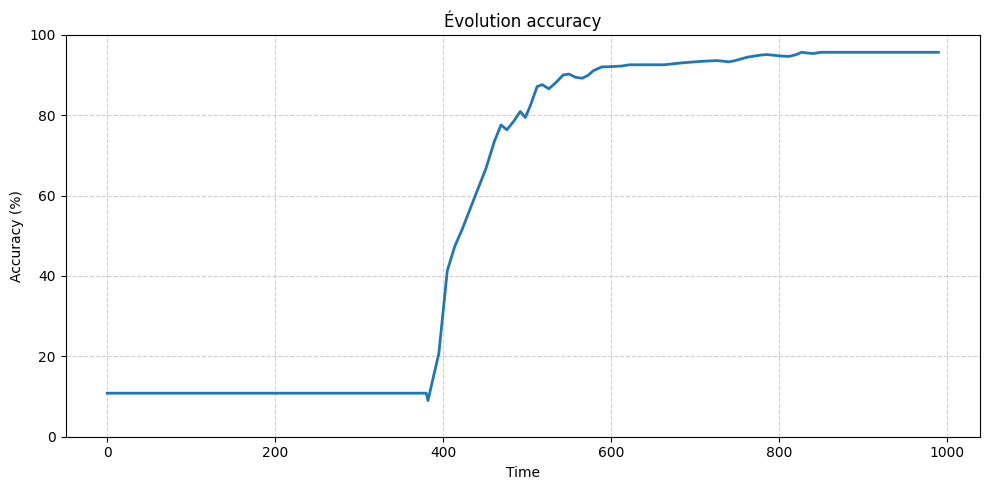

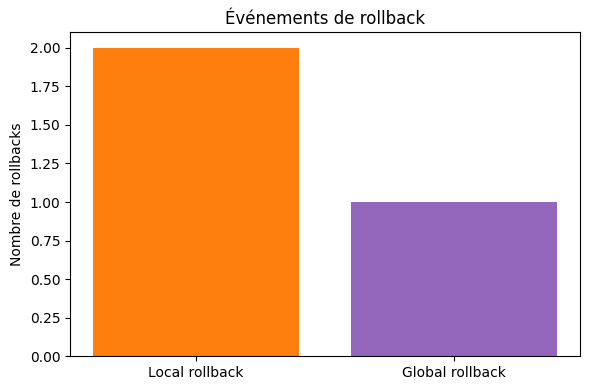

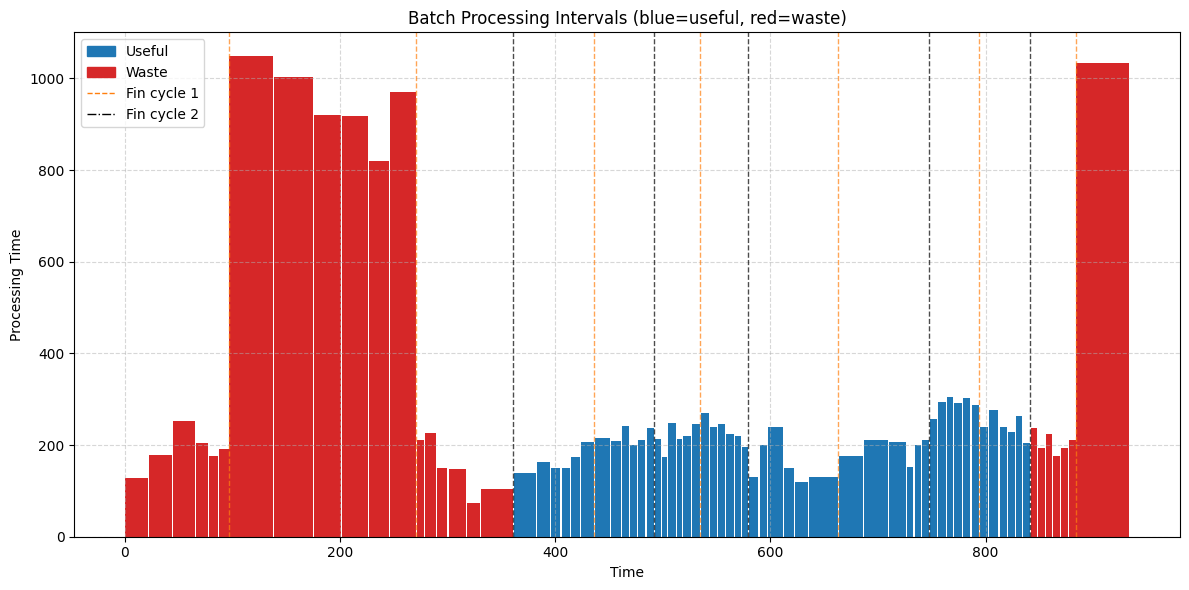

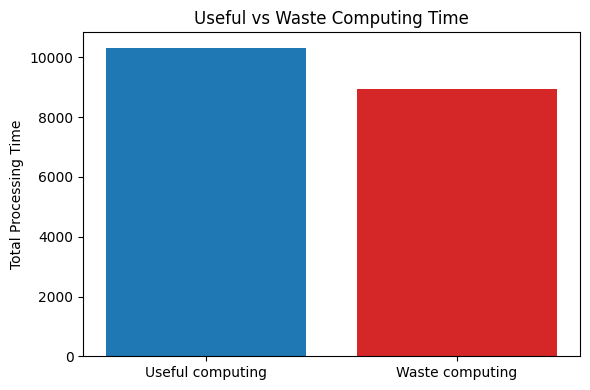

Total useful computing time: 10324
Total waste computing time: 8959
Ratio useful/(useful+waste): 53.54%


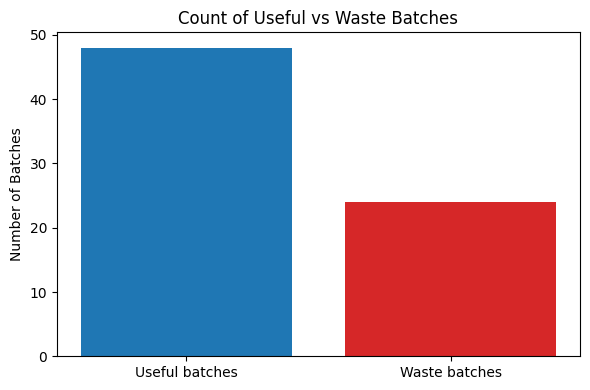

Total useful batches: 48
Total waste batches: 24
Ratio useful/(useful+waste): 66.67%
102
102
✔️ Honest worker coverage: 144/180 → 80.00%

--- Simulation avec 15% de workers byzantins ---


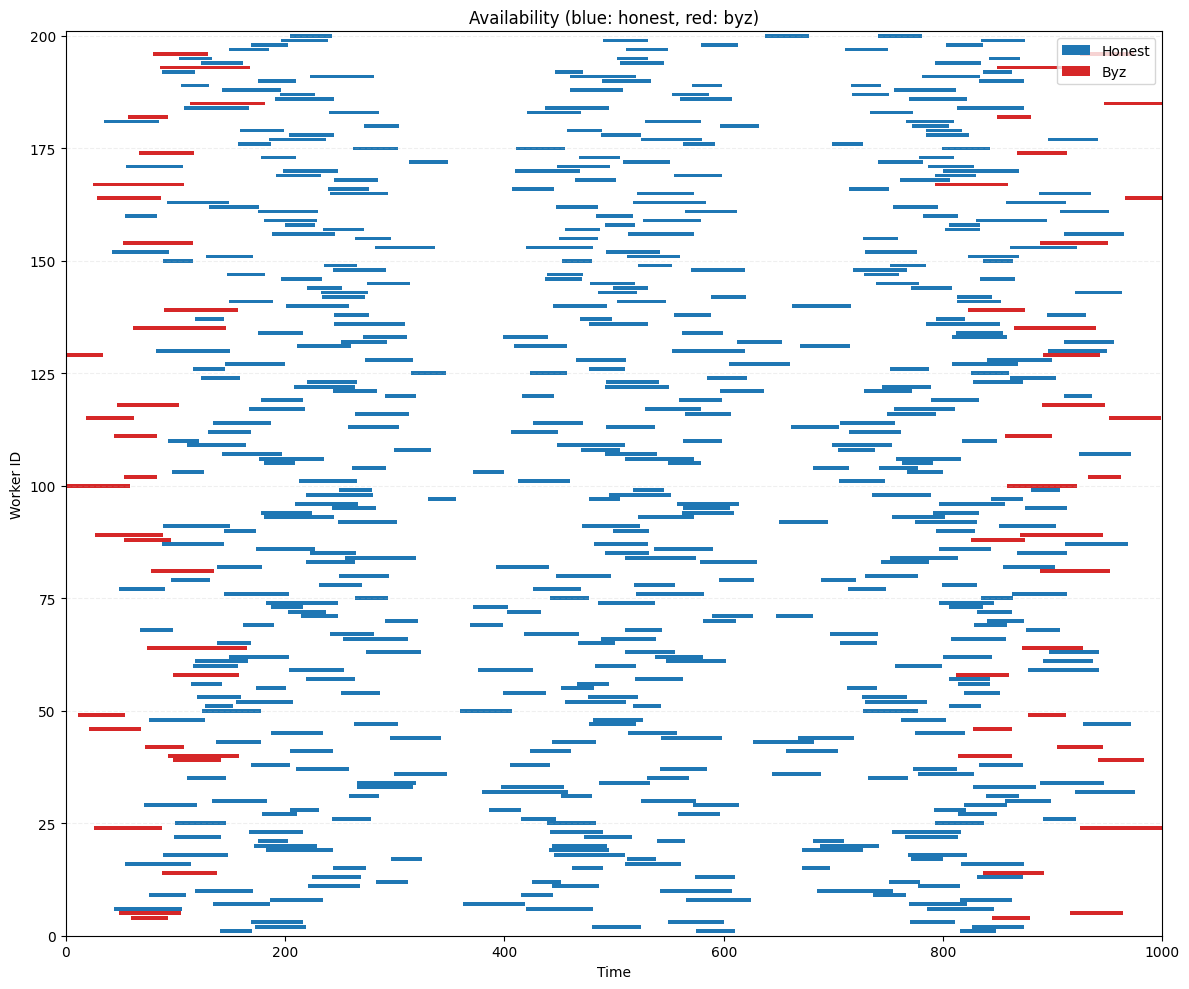

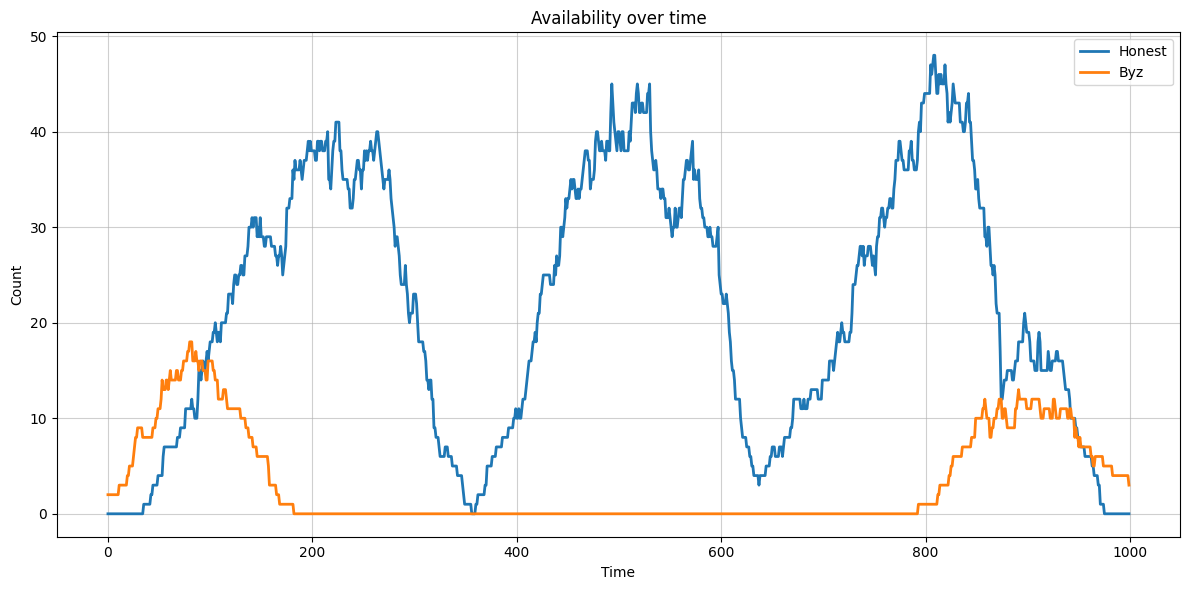

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 14.93%
[t=29] Cycle 1, batch #1 → Acc val: 10.53%
[t=46] Cycle 1, batch #2 → Acc val: 10.53%
[t=57] Cycle 1, batch #3 → Acc val: 10.53%
[t=66] Cycle 1, batch #4 → Acc val: 10.53%
[t=75] Cycle 1, batch #5 → Acc val: 10.53%
[t=82] Cycle 1, batch #6 → Acc val: 10.53%
[t=82] = Base rollback pour cycle 2 mise à jour
[t=82] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=82] Reset after rollback to majority
[t=118] Cycle 1, batch #1 → Acc val: 10.53%
[t=137] Cycle 1, batch #2 → Acc val: 10.53%
[t=170] Cycle 1, batch #3 → Acc val: 10.53%
[t=200] Cycle 1, batch #4 → Acc val: 10.53%
[t=228] Cycle 1, batch #5 → Acc val: 10.53%
[t=257] Cycle 1, batch #6 → Acc val: 10.53%
[t=257] = Base rollback pour cycle 2 mise à jour
[t=265] Cycle 2, batch #1 → Acc val: 10.53%
[t=272] Cycle 2, batch #2 → Acc val: 10.53%
[t=279] Cycle 2, batch #3 → Acc val: 10.53%
[t=289] Cycle 2, batch #4 → Acc val: 10.53%
[t=298] Cycle 2, batch #5 → Acc val

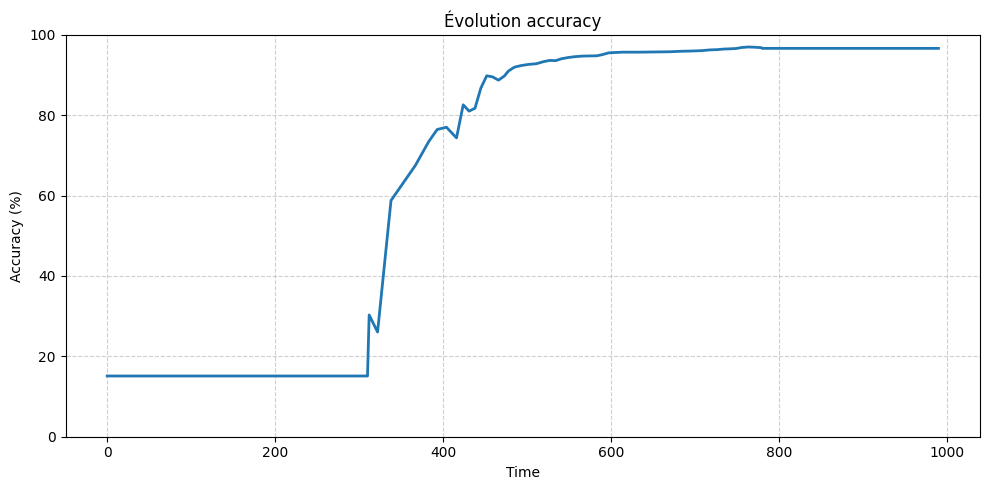

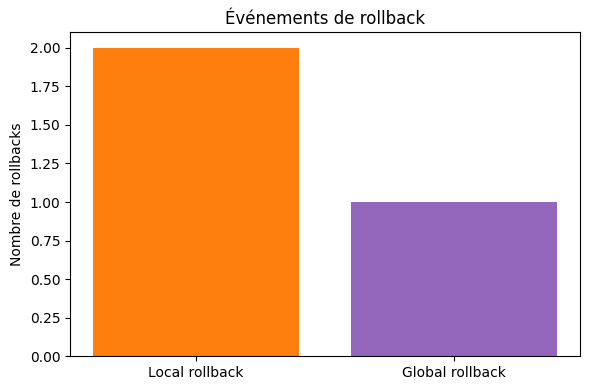

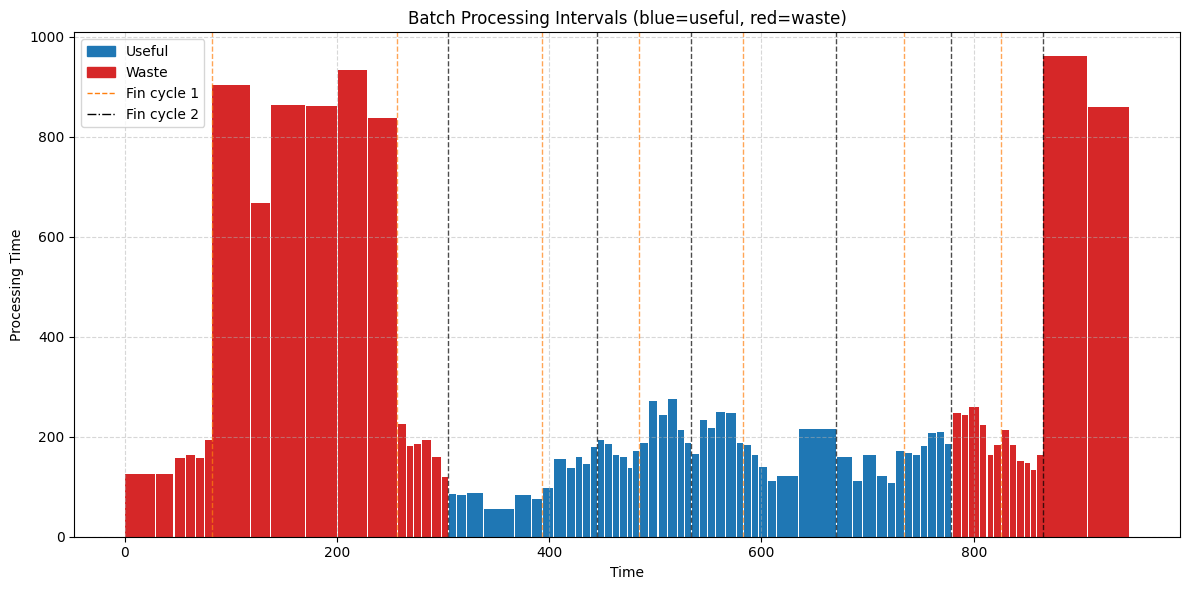

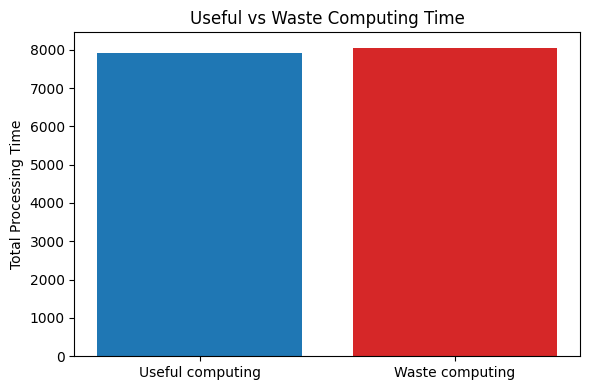

Total useful computing time: 7926
Total waste computing time: 8050
Ratio useful/(useful+waste): 49.61%


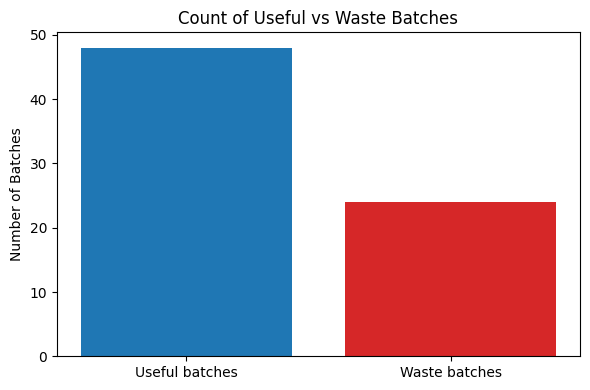

Total useful batches: 48
Total waste batches: 24
Ratio useful/(useful+waste): 66.67%
102
102
✔️ Honest worker coverage: 138/170 → 81.18%

--- Simulation avec 20% de workers byzantins ---


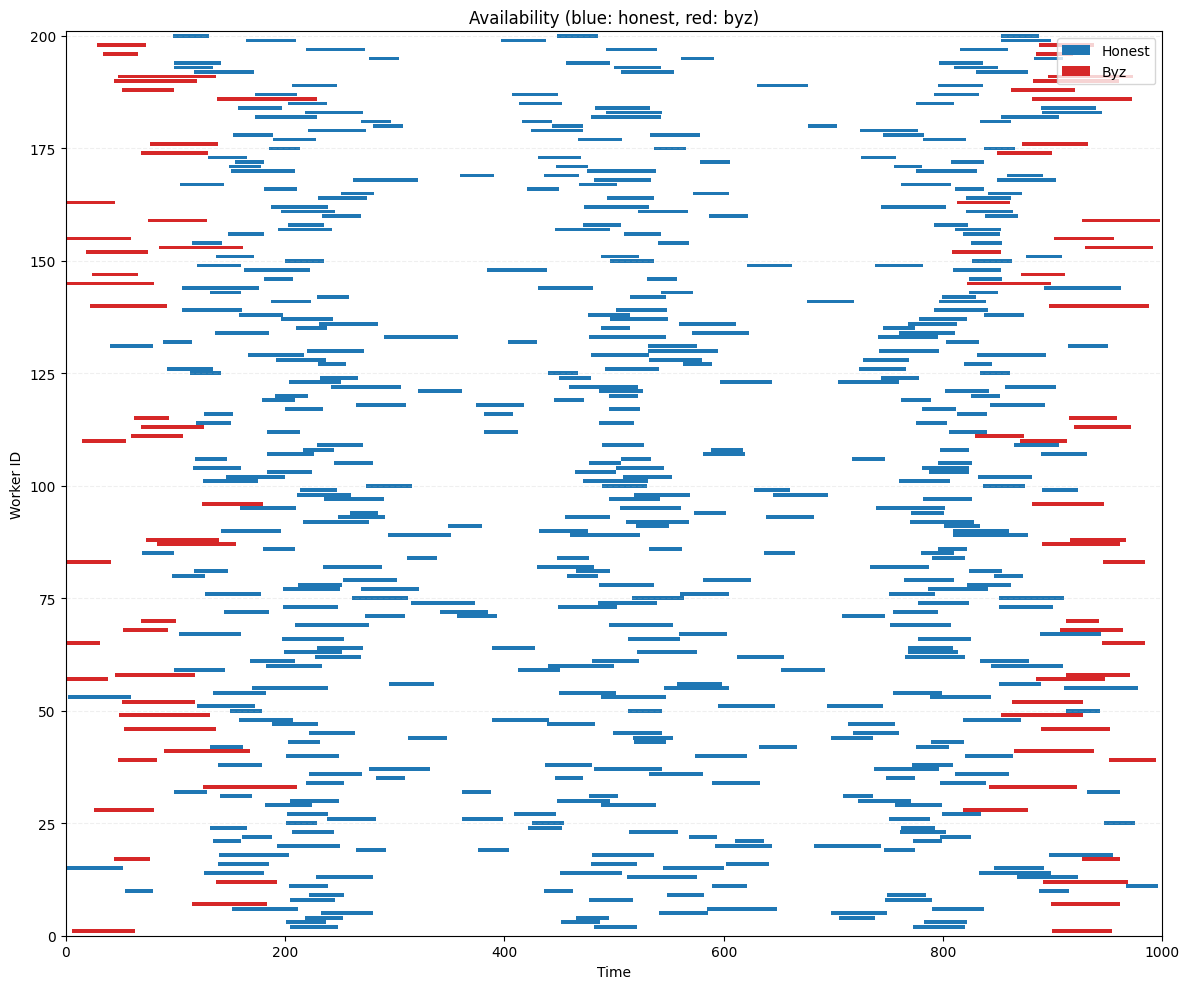

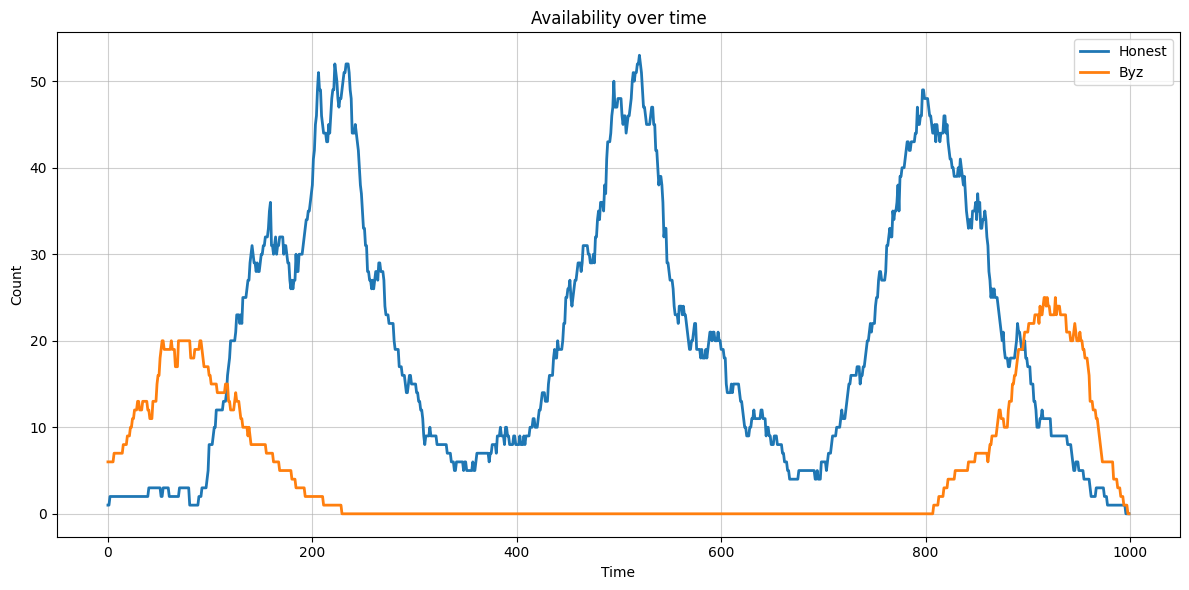

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 12.32%
[t=15] Cycle 1, batch #1 → Acc val: 11.29%
[t=28] Cycle 1, batch #2 → Acc val: 11.29%
[t=41] Cycle 1, batch #3 → Acc val: 11.29%
[t=51] Cycle 1, batch #4 → Acc val: 11.29%
[t=60] Cycle 1, batch #5 → Acc val: 11.29%
[t=67] Cycle 1, batch #6 → Acc val: 11.29%
[t=67] = Base rollback pour cycle 2 mise à jour
[t=67] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=67] Reset after rollback to majority
[t=118] Cycle 1, batch #1 → Acc val: 11.29%
[t=147] Cycle 1, batch #2 → Acc val: 11.29%
[t=171] Cycle 1, batch #3 → Acc val: 11.29%
[t=199] Cycle 1, batch #4 → Acc val: 11.29%
[t=217] Cycle 1, batch #5 → Acc val: 11.29%
[t=234] Cycle 1, batch #6 → Acc val: 11.29%
[t=234] = Base rollback pour cycle 2 mise à jour
[t=241] Cycle 2, batch #1 → Acc val: 11.29%
[t=248] Cycle 2, batch #2 → Acc val: 11.29%
[t=255] Cycle 2, batch #3 → Acc val: 11.29%
[t=263] Cycle 2, batch #4 → Acc val: 11.29%
[t=272] Cycle 2, batch #5 → Acc val

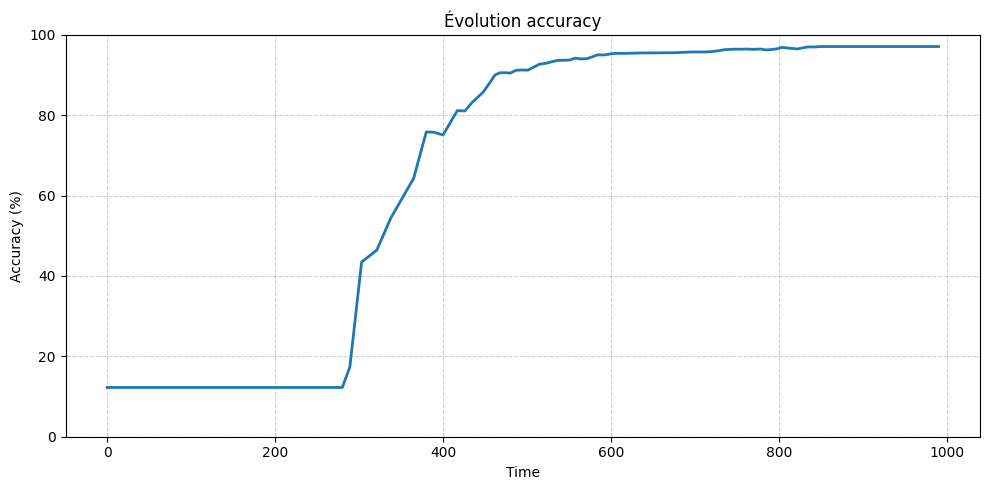

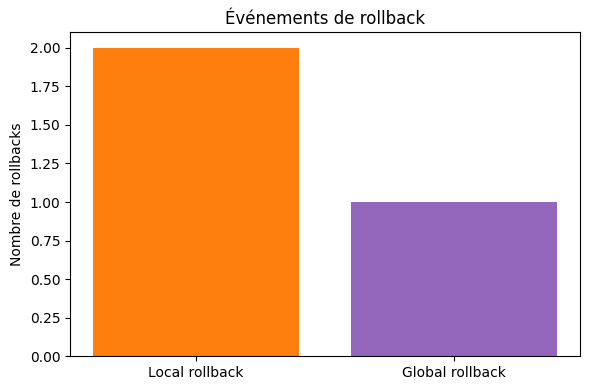

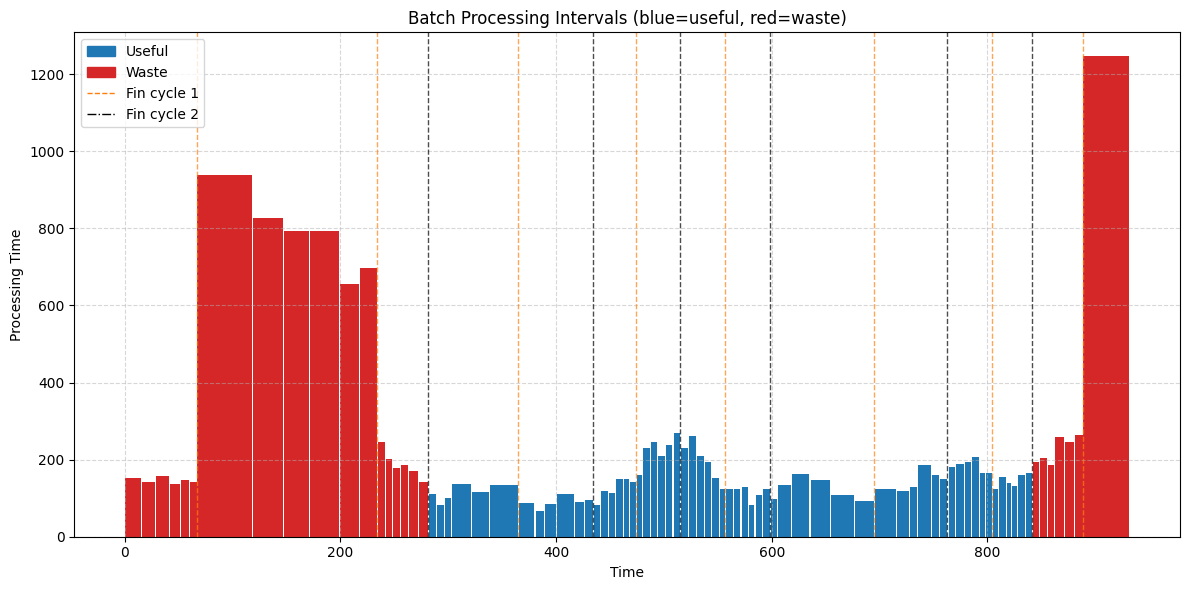

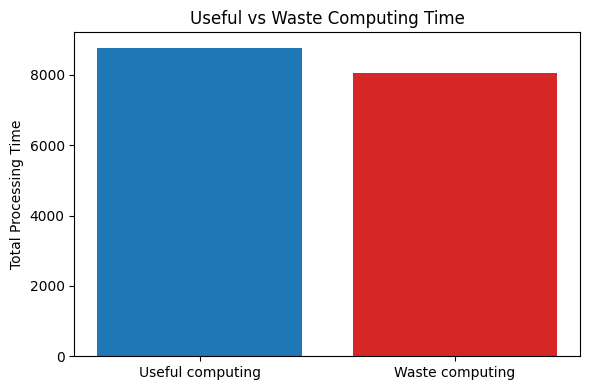

Total useful computing time: 8772
Total waste computing time: 8057
Ratio useful/(useful+waste): 52.12%


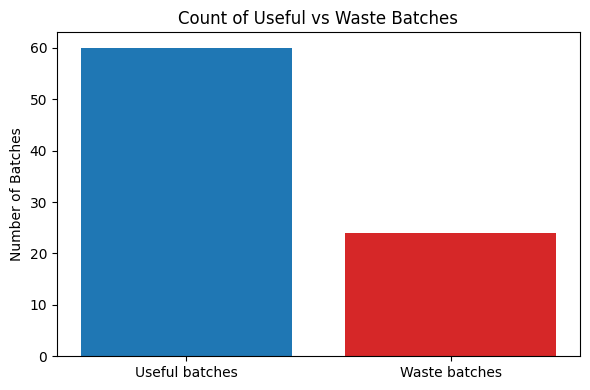

Total useful batches: 60
Total waste batches: 24
Ratio useful/(useful+waste): 71.43%
104
104
✔️ Honest worker coverage: 122/160 → 76.25%

--- Simulation avec 25% de workers byzantins ---


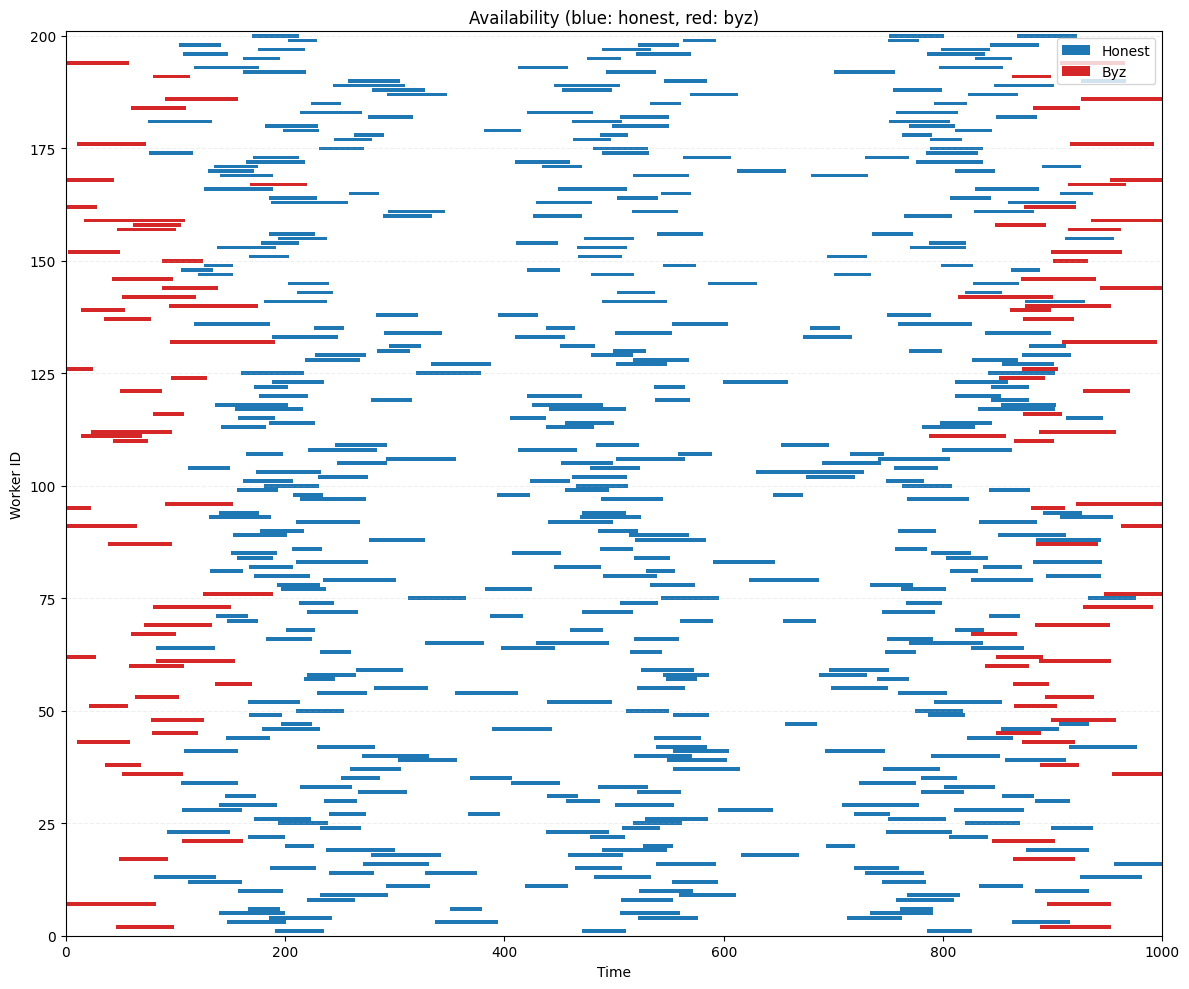

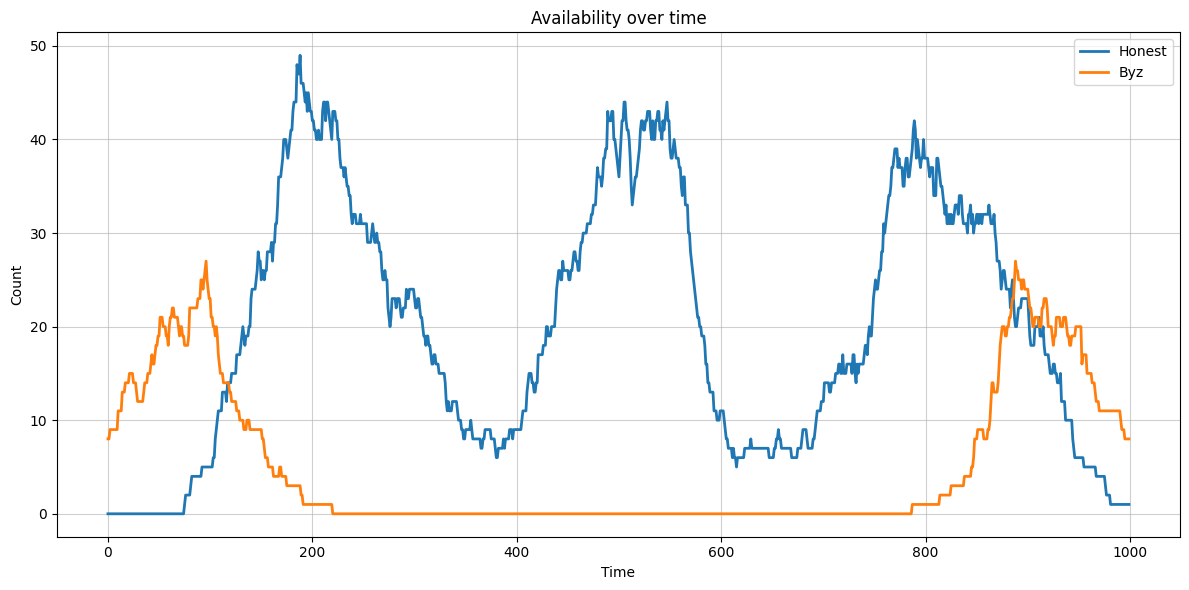

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 4.86%
[t=9] Cycle 1, batch #1 → Acc val: 8.98%
[t=19] Cycle 1, batch #2 → Acc val: 8.98%
[t=30] Cycle 1, batch #3 → Acc val: 8.98%
[t=43] Cycle 1, batch #4 → Acc val: 8.98%
[t=53] Cycle 1, batch #5 → Acc val: 8.98%
[t=63] Cycle 1, batch #6 → Acc val: 8.98%
[t=63] = Base rollback pour cycle 2 mise à jour
[t=63] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=63] Reset after rollback to majority
[t=112] Cycle 1, batch #1 → Acc val: 8.98%
[t=160] Cycle 1, batch #2 → Acc val: 8.98%
[t=183] Cycle 1, batch #3 → Acc val: 8.98%
[t=204] Cycle 1, batch #4 → Acc val: 8.98%
[t=225] Cycle 1, batch #5 → Acc val: 8.98%
[t=252] Cycle 1, batch #6 → Acc val: 8.98%
[t=252] = Base rollback pour cycle 2 mise à jour
[t=259] Cycle 2, batch #1 → Acc val: 8.98%
[t=267] Cycle 2, batch #2 → Acc val: 8.98%
[t=275] Cycle 2, batch #3 → Acc val: 8.98%
[t=283] Cycle 2, batch #4 → Acc val: 8.98%
[t=291] Cycle 2, batch #5 → Acc val: 8.98%
[t=302] Cy

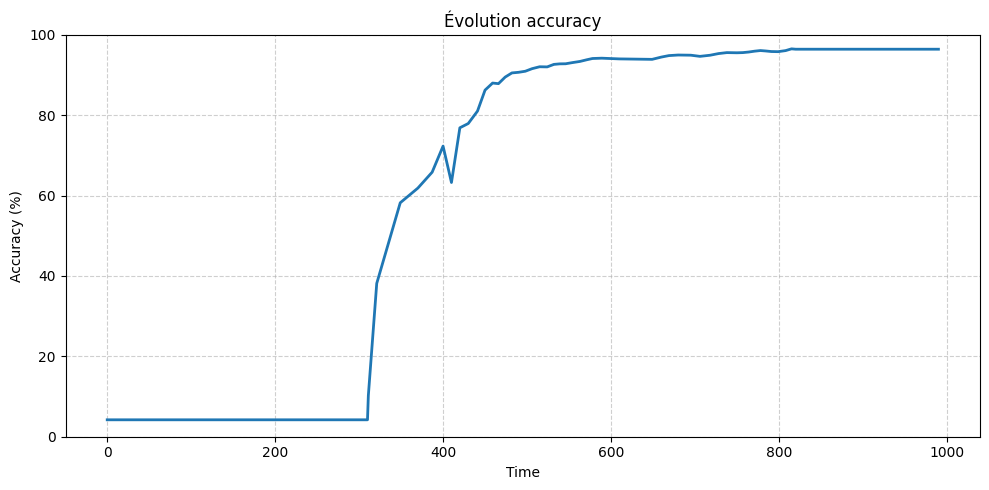

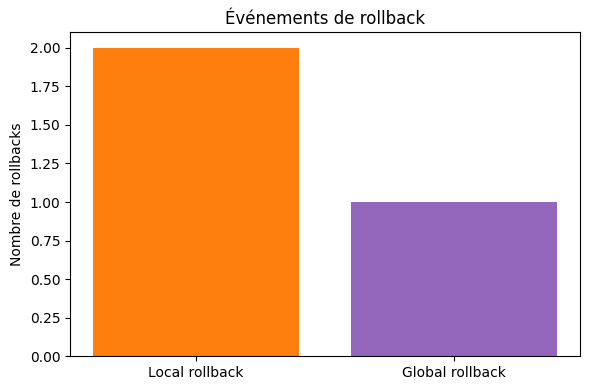

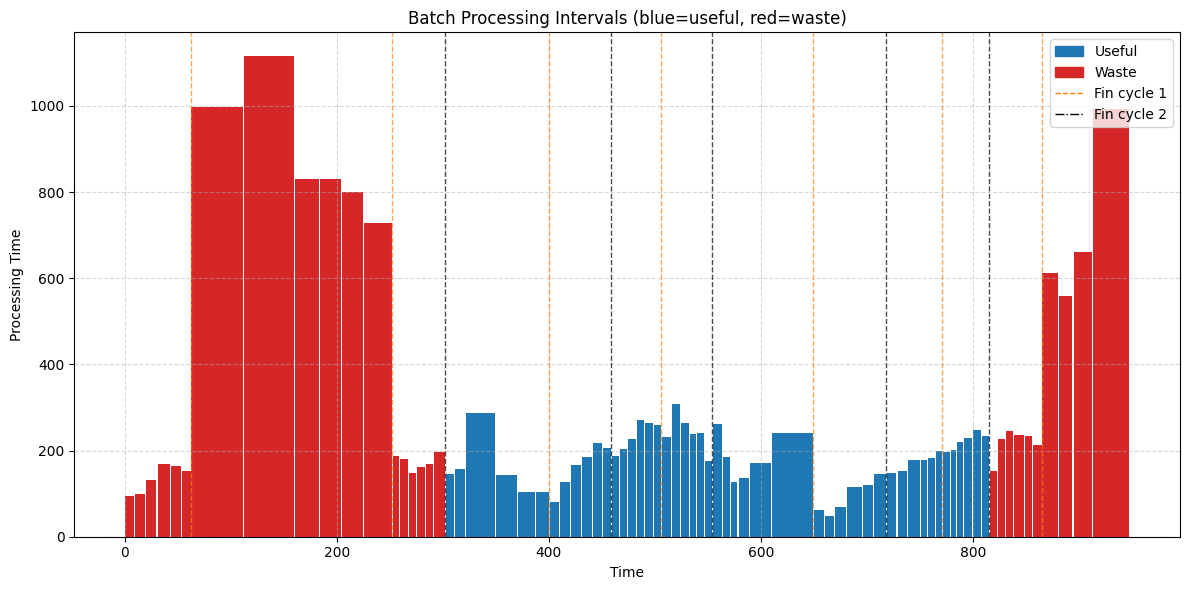

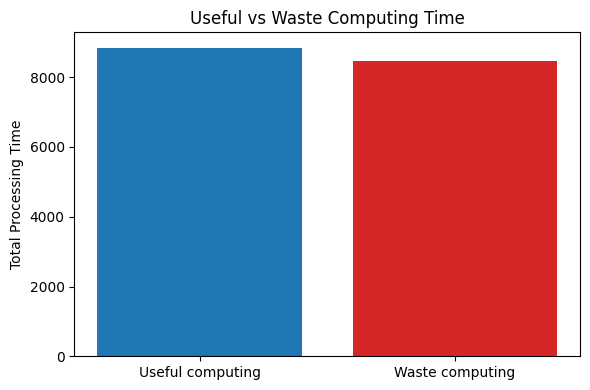

Total useful computing time: 8844
Total waste computing time: 8464
Ratio useful/(useful+waste): 51.10%


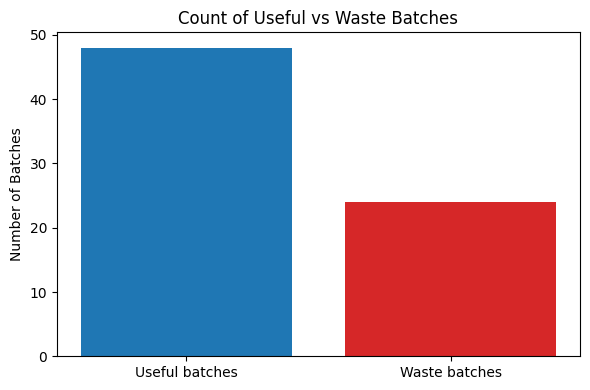

Total useful batches: 48
Total waste batches: 24
Ratio useful/(useful+waste): 66.67%
98
98
✔️ Honest worker coverage: 125/150 → 83.33%

--- Simulation avec 30% de workers byzantins ---


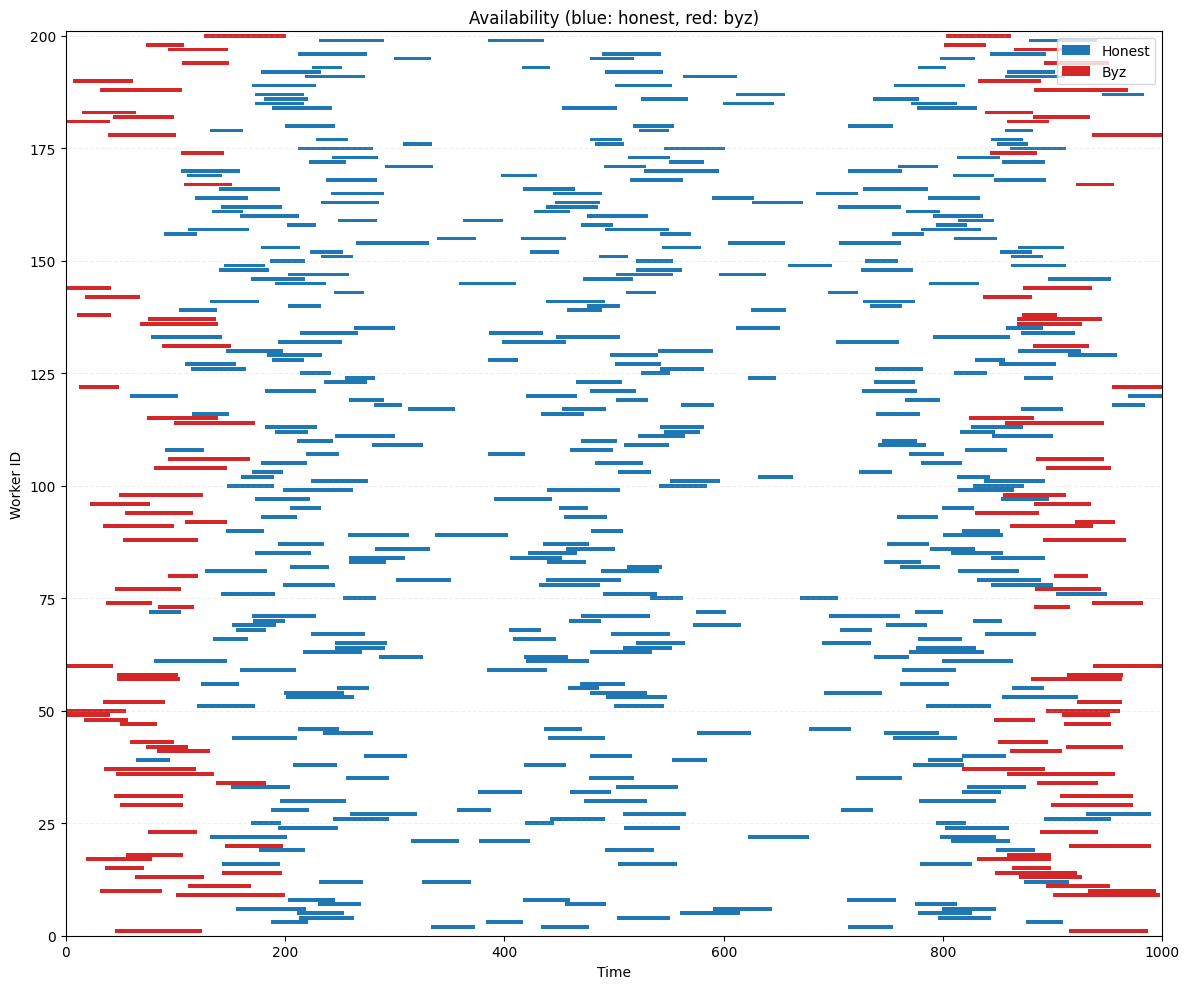

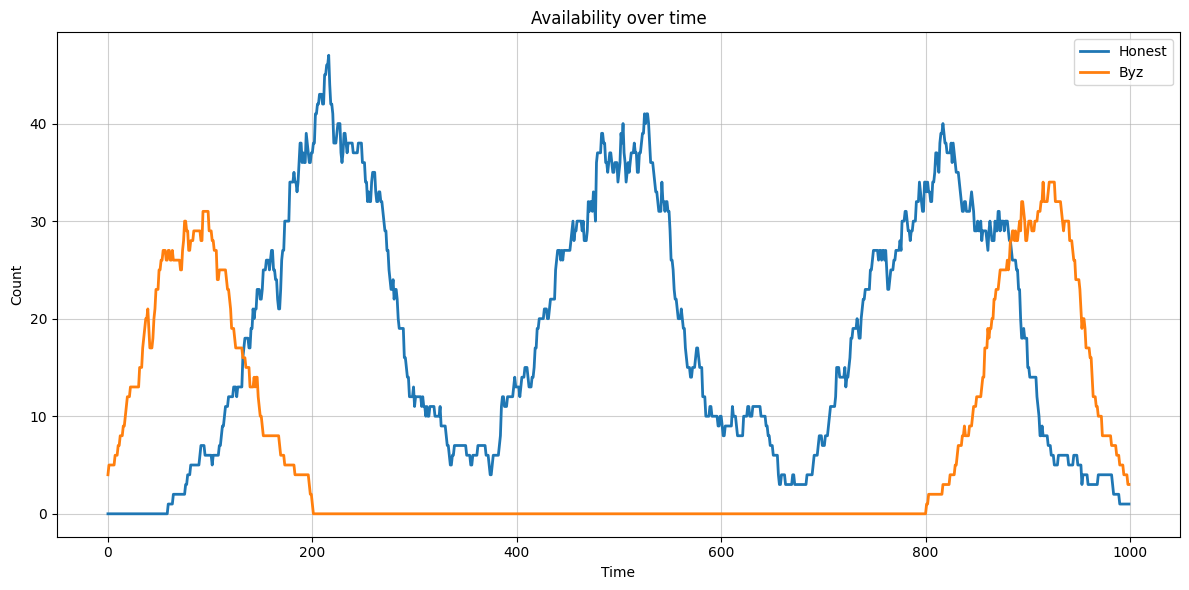

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 10.13%
[t=18] Cycle 1, batch #1 → Acc val: 9.62%
[t=27] Cycle 1, batch #2 → Acc val: 9.62%
[t=36] Cycle 1, batch #3 → Acc val: 9.62%
[t=45] Cycle 1, batch #4 → Acc val: 9.62%
[t=54] Cycle 1, batch #5 → Acc val: 9.62%
[t=63] Cycle 1, batch #6 → Acc val: 9.62%
[t=63] = Base rollback pour cycle 2 mise à jour
[t=63] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=63] Reset after rollback to majority
[t=112] Cycle 1, batch #1 → Acc val: 9.62%
[t=140] Cycle 1, batch #2 → Acc val: 9.62%
[t=185] Cycle 1, batch #3 → Acc val: 9.62%
[t=214] Cycle 1, batch #4 → Acc val: 9.62%
[t=231] Cycle 1, batch #5 → Acc val: 9.62%
[t=251] Cycle 1, batch #6 → Acc val: 9.62%
[t=251] = Base rollback pour cycle 2 mise à jour
[t=260] Cycle 2, batch #1 → Acc val: 9.62%
[t=267] Cycle 2, batch #2 → Acc val: 9.62%
[t=274] Cycle 2, batch #3 → Acc val: 9.62%
[t=284] Cycle 2, batch #4 → Acc val: 9.62%
[t=295] Cycle 2, batch #5 → Acc val: 9.62%
[t=312] 

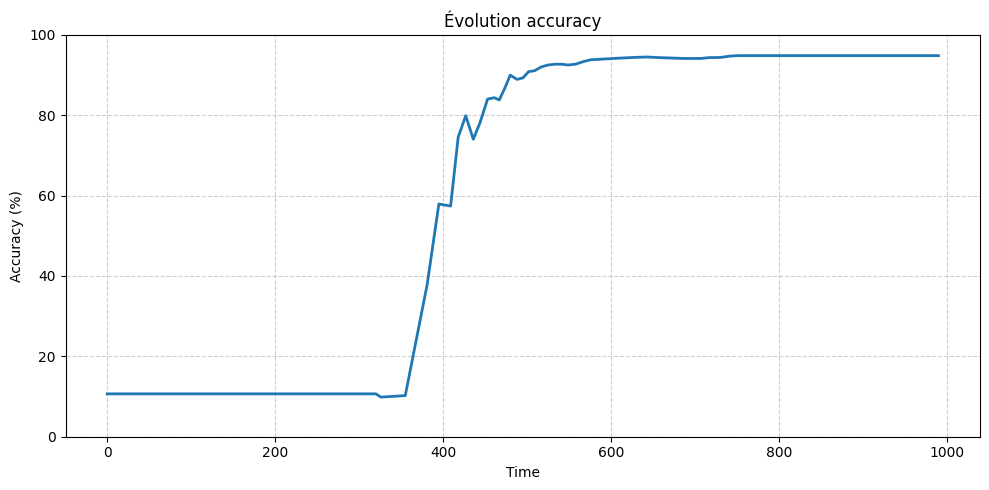

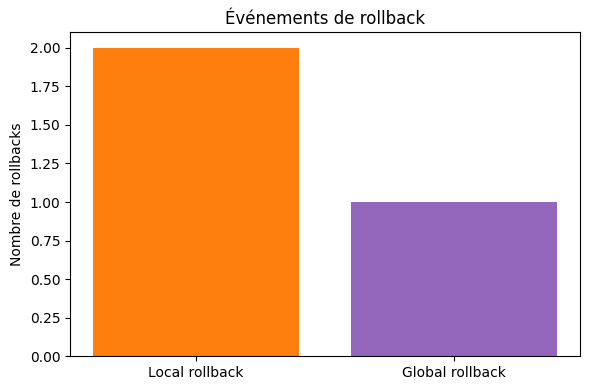

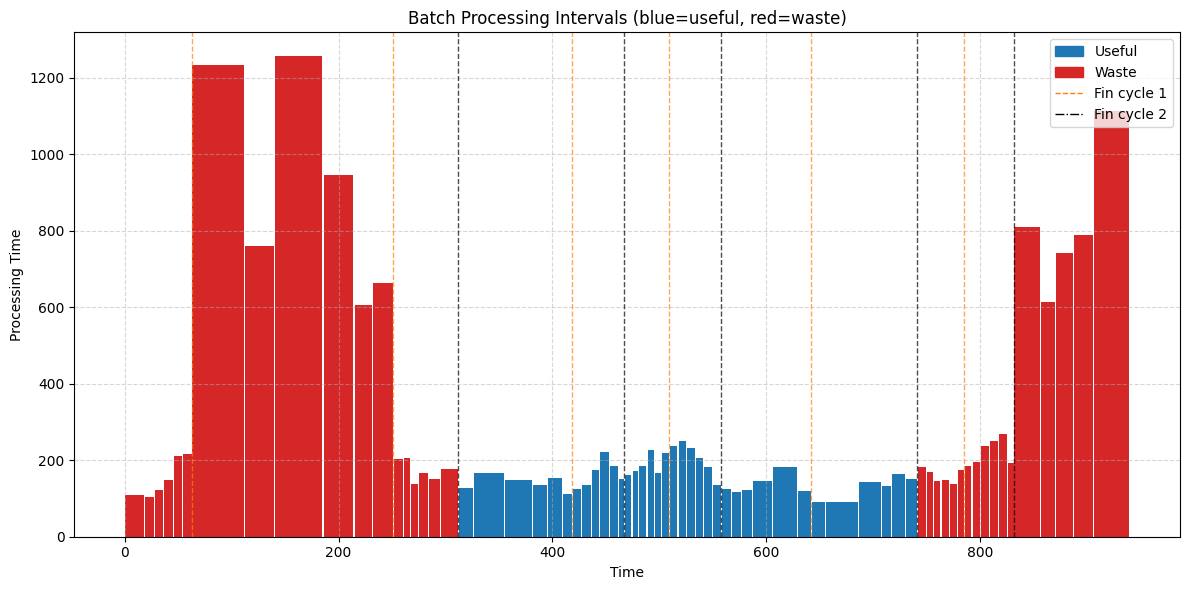

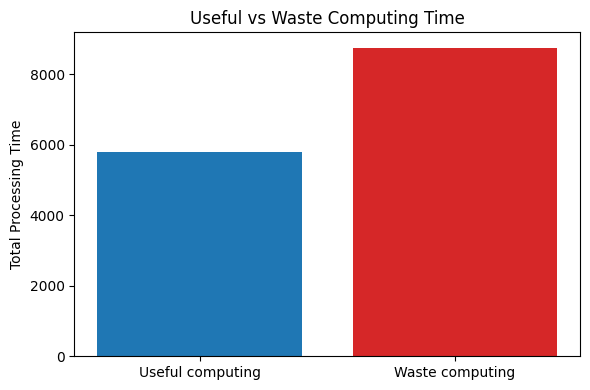

Total useful computing time: 5800
Total waste computing time: 8747
Ratio useful/(useful+waste): 39.87%


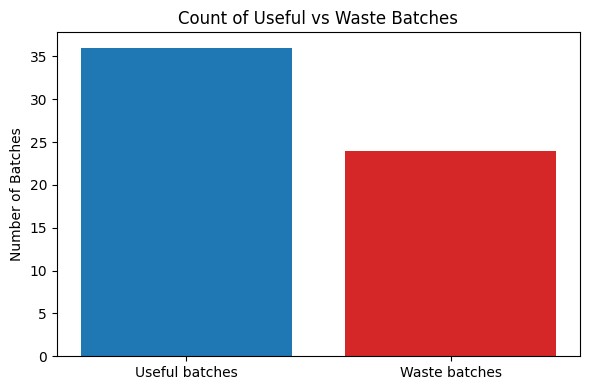

Total useful batches: 36
Total waste batches: 24
Ratio useful/(useful+waste): 60.00%
94
94
✔️ Honest worker coverage: 118/140 → 84.29%

--- Simulation avec 35% de workers byzantins ---


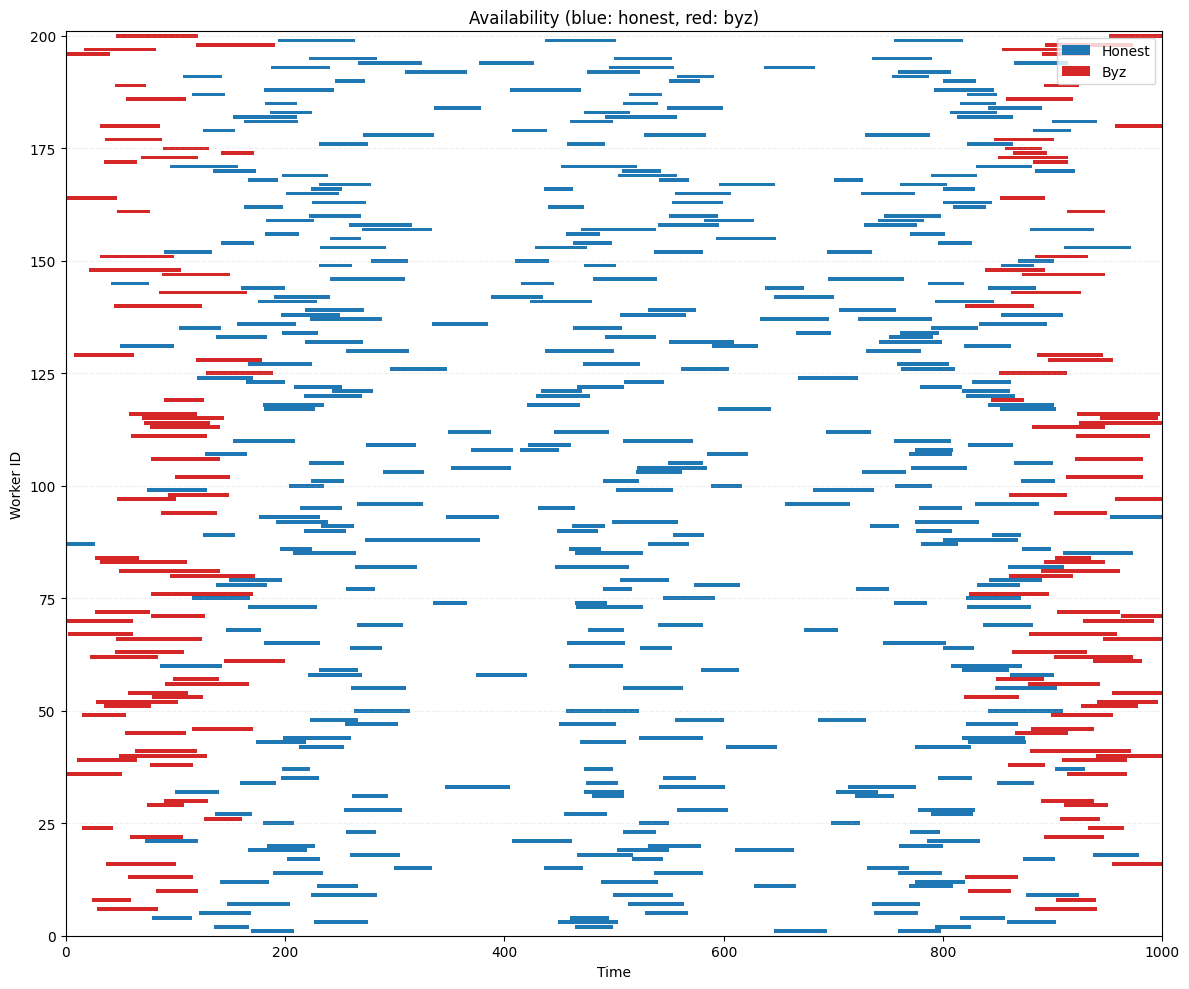

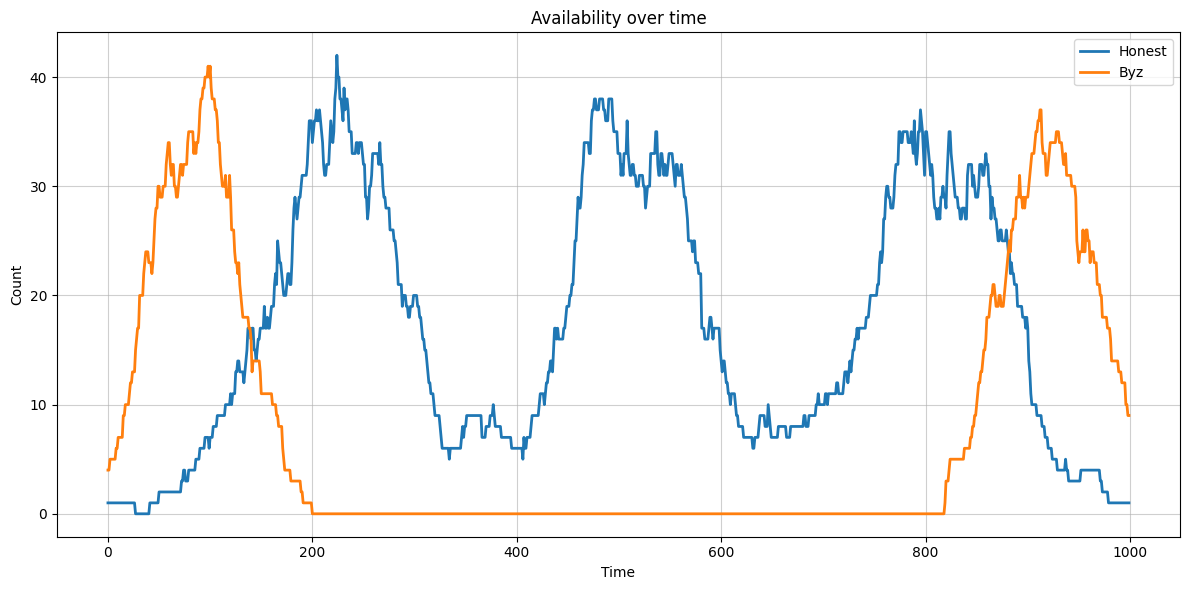

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 13.02%
[t=18] Cycle 1, batch #1 → Acc val: 10.53%
[t=32] Cycle 1, batch #2 → Acc val: 10.53%
[t=41] Cycle 1, batch #3 → Acc val: 10.53%
[t=49] Cycle 1, batch #4 → Acc val: 10.53%
[t=58] Cycle 1, batch #5 → Acc val: 10.53%
[t=66] Cycle 1, batch #6 → Acc val: 10.53%
[t=66] = Base rollback pour cycle 2 mise à jour
[t=66] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=66] Reset after rollback to majority
[t=104] Cycle 1, batch #1 → Acc val: 10.53%
[t=133] Cycle 1, batch #2 → Acc val: 10.53%
[t=164] Cycle 1, batch #3 → Acc val: 10.53%
[t=204] Cycle 1, batch #4 → Acc val: 10.53%
[t=237] Cycle 1, batch #5 → Acc val: 10.53%
[t=274] Cycle 1, batch #6 → Acc val: 10.53%
[t=274] = Base rollback pour cycle 2 mise à jour
[t=283] Cycle 2, batch #1 → Acc val: 10.53%
[t=294] Cycle 2, batch #2 → Acc val: 10.53%
[t=311] Cycle 2, batch #3 → Acc val: 10.53%
[t=341] Cycle 2, batch #4 → Acc val: 10.53%
[t=371] Cycle 2, batch #5 → Acc val

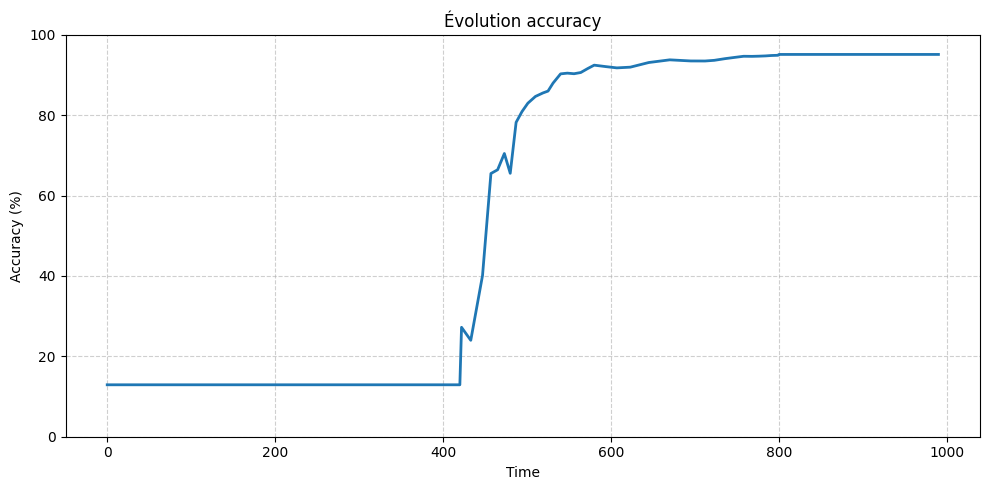

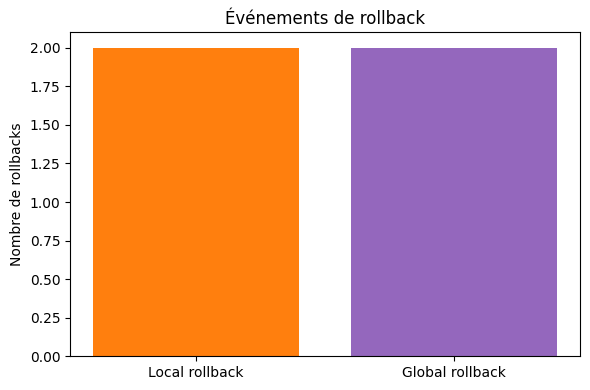

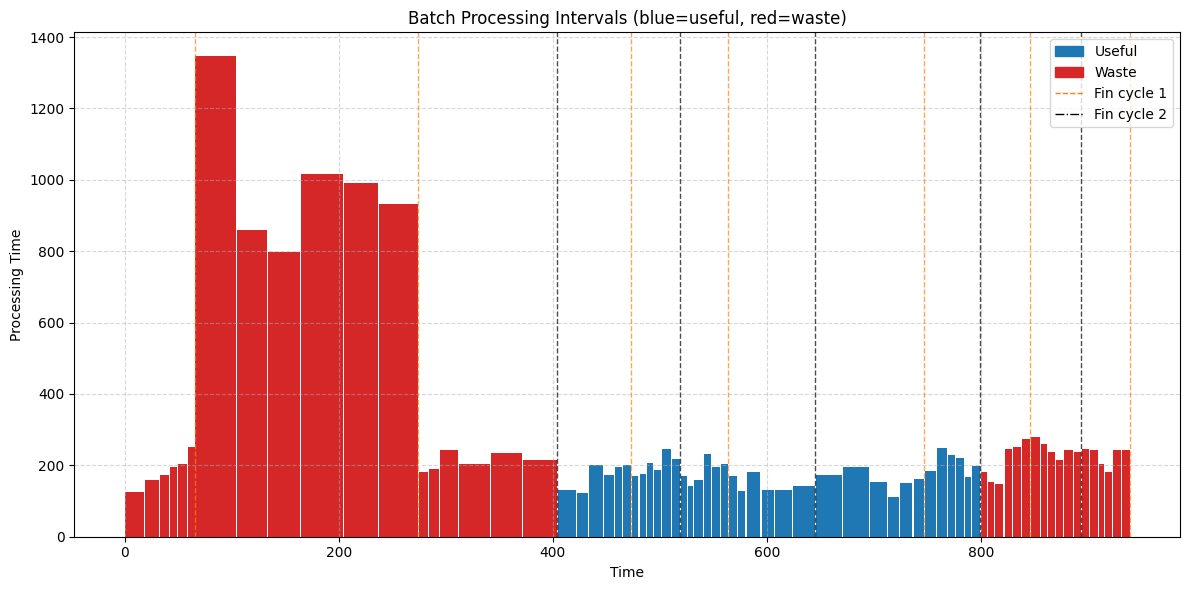

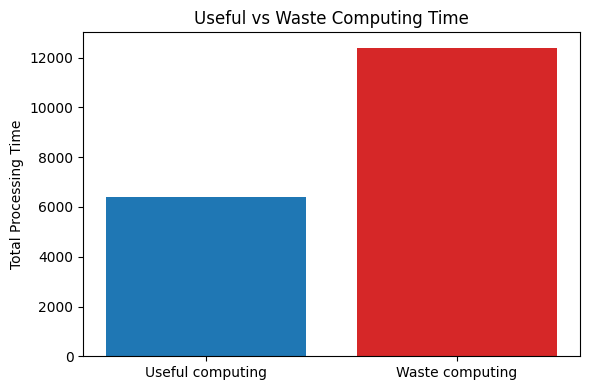

Total useful computing time: 6419
Total waste computing time: 12397
Ratio useful/(useful+waste): 34.11%


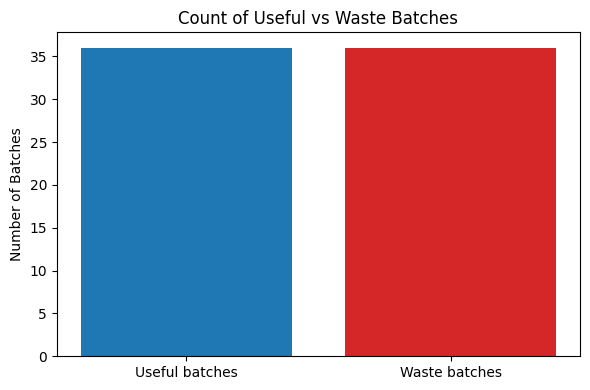

Total useful batches: 36
Total waste batches: 36
Ratio useful/(useful+waste): 50.00%
99
99
✔️ Honest worker coverage: 109/130 → 83.85%

--- Simulation avec 40% de workers byzantins ---


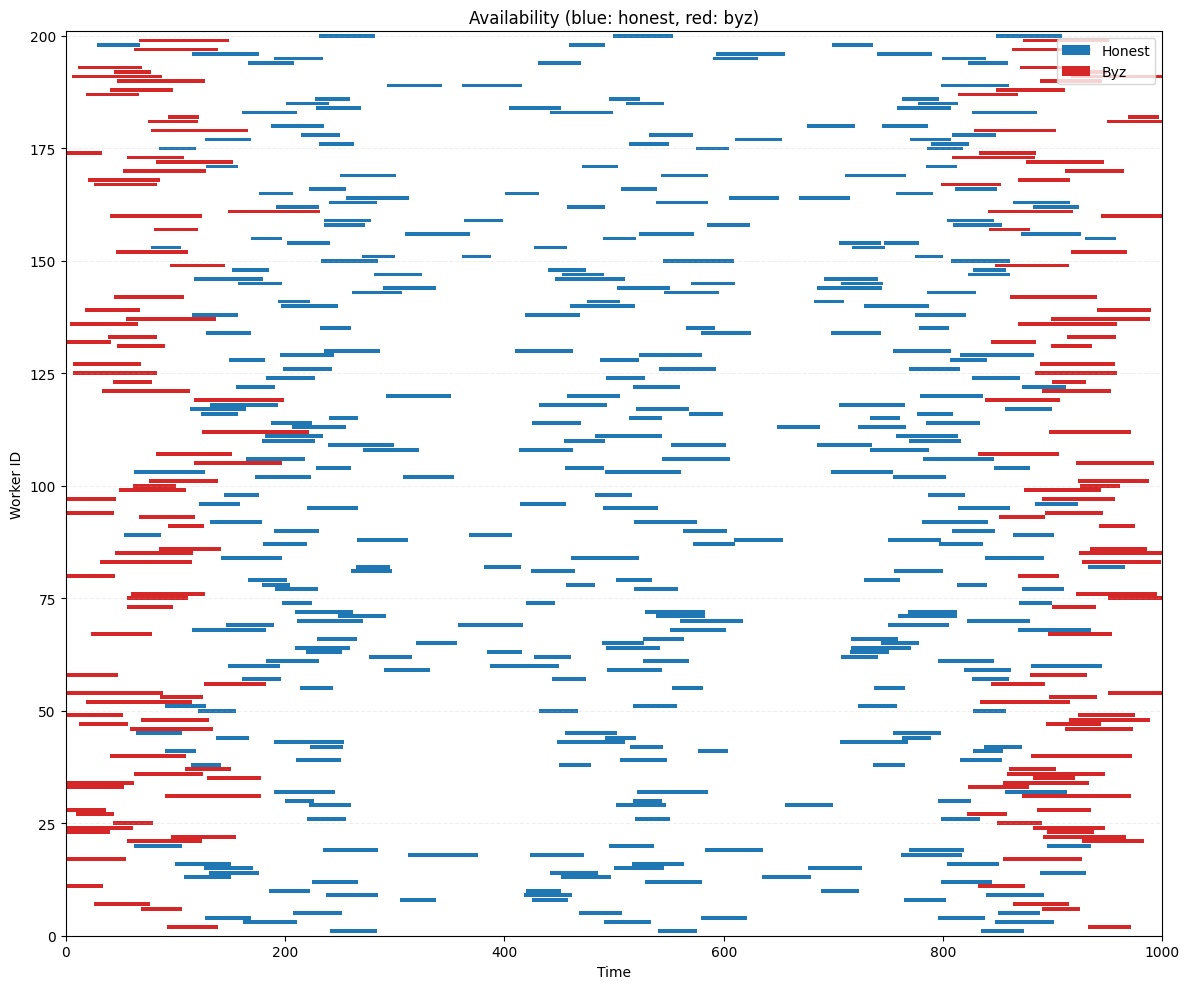

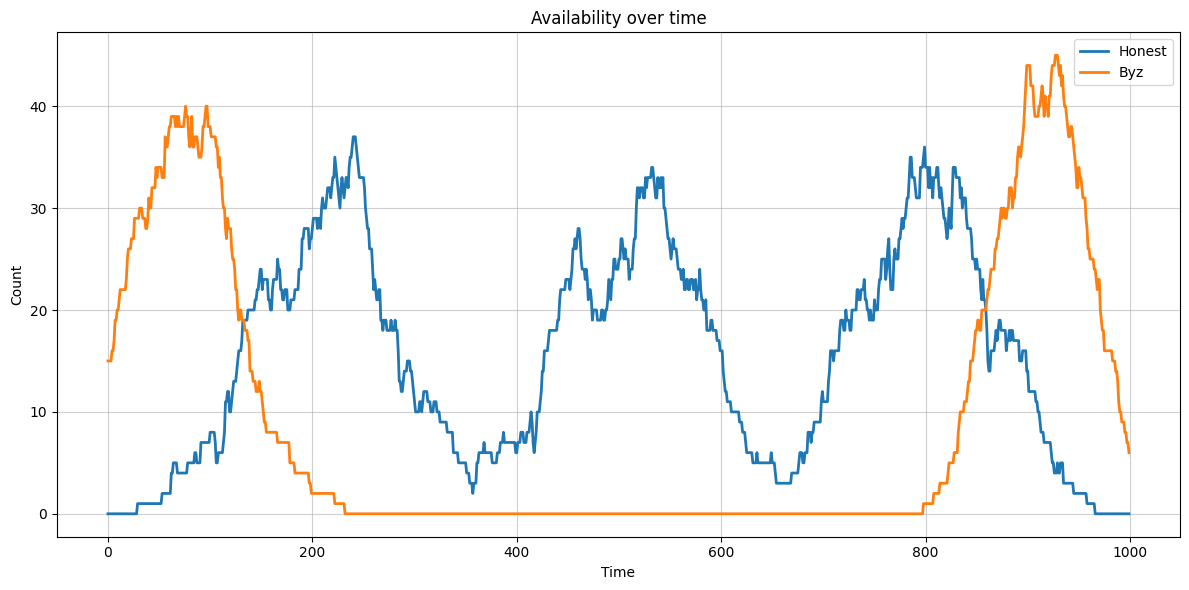

[t=0] = Safe-point ACTUEL cycle 0 — Acc: 8.46%
[t=10] Cycle 1, batch #1 → Acc val: 10.53%
[t=18] Cycle 1, batch #2 → Acc val: 10.53%
[t=26] Cycle 1, batch #3 → Acc val: 10.53%
[t=33] Cycle 1, batch #4 → Acc val: 10.53%
[t=41] Cycle 1, batch #5 → Acc val: 10.53%
[t=49] Cycle 1, batch #6 → Acc val: 10.53%
[t=49] = Base rollback pour cycle 2 mise à jour
[t=49] Rollback cycle 1 → vote-majorité
Waste batches cycle 1: [1, 2, 3, 4, 5, 6]
[t=49] Reset after rollback to majority
[t=82] Cycle 1, batch #1 → Acc val: 10.53%
[t=107] Cycle 1, batch #2 → Acc val: 10.53%
[t=139] Cycle 1, batch #3 → Acc val: 10.53%
[t=176] Cycle 1, batch #4 → Acc val: 10.53%
[t=215] Cycle 1, batch #5 → Acc val: 10.53%
[t=242] Cycle 1, batch #6 → Acc val: 10.53%
[t=242] = Base rollback pour cycle 2 mise à jour
[t=249] Cycle 2, batch #1 → Acc val: 10.53%
[t=256] Cycle 2, batch #2 → Acc val: 10.53%
[t=271] Cycle 2, batch #3 → Acc val: 10.53%
[t=282] Cycle 2, batch #4 → Acc val: 10.53%
[t=297] Cycle 2, batch #5 → Acc val: 

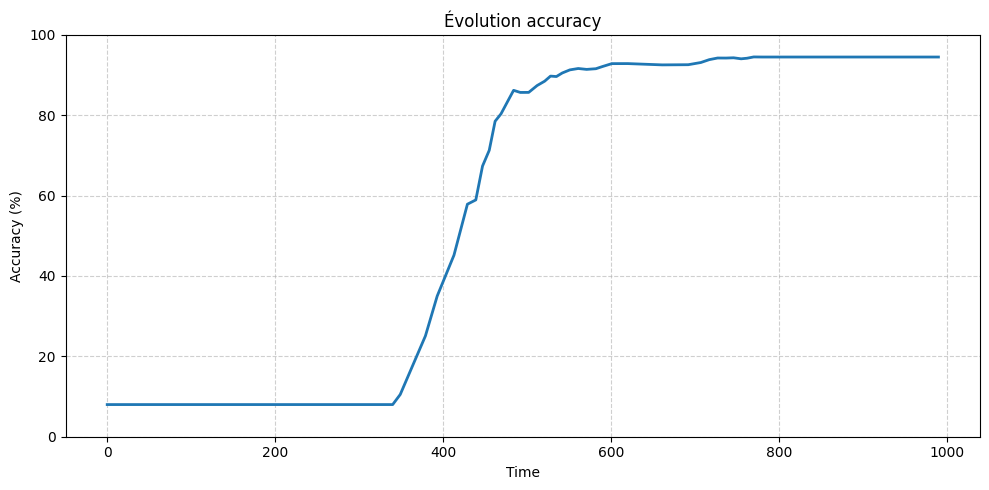

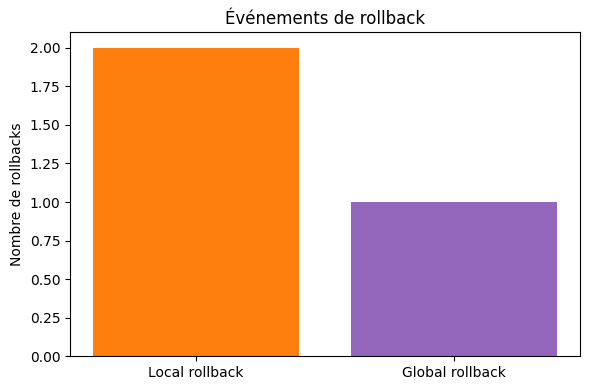

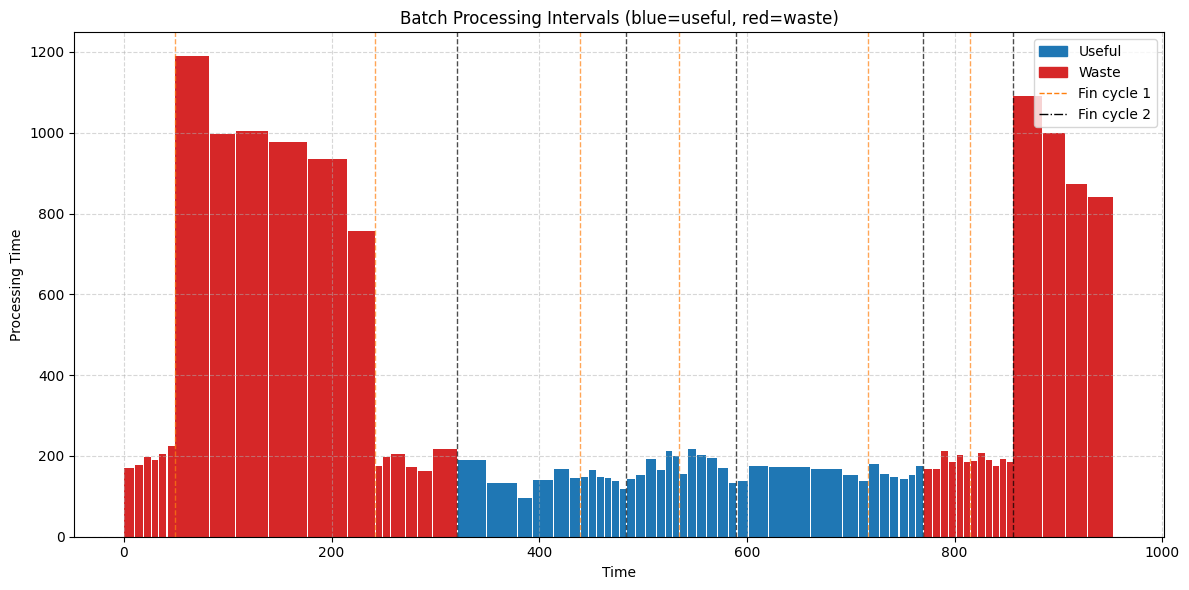

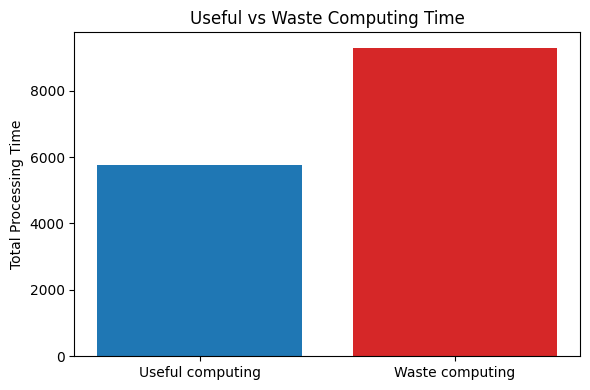

Total useful computing time: 5775
Total waste computing time: 9291
Ratio useful/(useful+waste): 38.33%


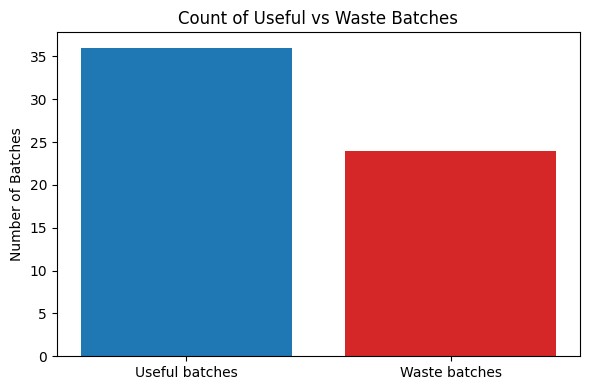

Total useful batches: 36
Total waste batches: 24
Ratio useful/(useful+waste): 60.00%
93
93
✔️ Honest worker coverage: 110/120 → 91.67%

[BASELINE] Accuracy sans attaques, sans défense : 98.20%
[0% byzantins] Accuracy : 97.19% → Robustesse : 98.97%
[5% byzantins] Accuracy : 95.66% → Robustesse : 97.41%
[10% byzantins] Accuracy : 95.66% → Robustesse : 97.41%
[15% byzantins] Accuracy : 96.63% → Robustesse : 98.40%
[20% byzantins] Accuracy : 97.09% → Robustesse : 98.87%
[25% byzantins] Accuracy : 96.42% → Robustesse : 98.19%
[30% byzantins] Accuracy : 94.82% → Robustesse : 96.56%
[35% byzantins] Accuracy : 95.12% → Robustesse : 96.87%
[40% byzantins] Accuracy : 94.48% → Robustesse : 96.21%


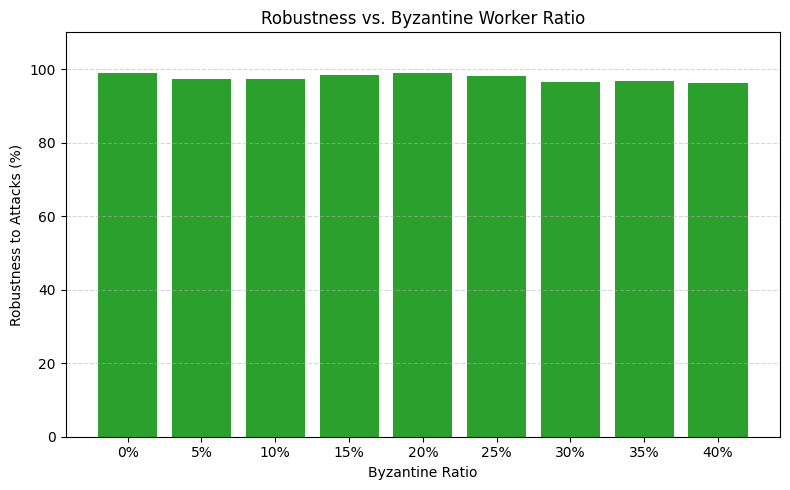

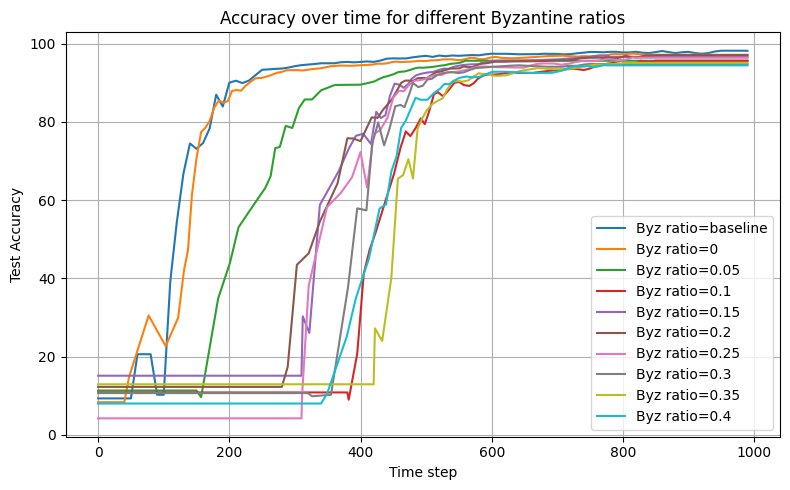

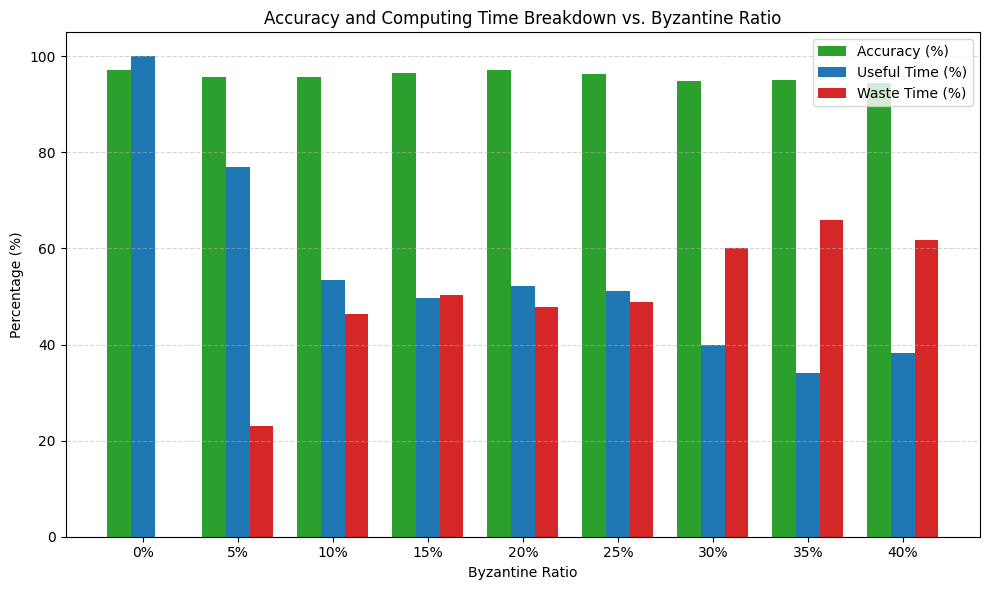

In [48]:
# -*- coding: utf-8 -*-
import random
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from matplotlib.patches import Patch
import matplotlib.lines as mlines

# ------------------------------------------------------------------------------
# Utilitaires de génération d'intervalles
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for curr in intervals[1:]:
        last = merged[-1]
        if curr[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], curr[1]))
        else:
            merged.append(curr)
    return merged

def generate_gaussian_availability(T,std_dev_ratio=0.065, min_pt=3,smooth=10):
    peaks = [0.2, 0.5, 0.8]
    sd = int(std_dev_ratio * T)
    periods = []
    for m in peaks:
        mu = int(m * T)
        start = int(np.random.normal(mu, sd))
        start = max(0, min(start, T - min_pt*3))
        dur = random.randint(min_pt*3, min(min_pt*5, T - start))
        periods.append((start, start + dur))
    merged = merge_intervals(periods)
    return merge_intervals([(max(0,s-smooth), min(T,e+smooth)) for s,e in merged])

def generate_gaussian_byzantine_availability(T,std_dev_ratio=0.04, min_pt=3,smooth=10):
    peaks = [0.06, 0.9]
    sd = int(std_dev_ratio * T)
    periods = []
    for m in peaks:
        mu = int(m * T)
        start = int(np.random.normal(mu, sd))
        start = max(0, min(start, T - min_pt*4))
        dur = random.randint(min_pt*4, min(min_pt*8, T - start))
        periods.append((start, start + dur))
    merged = merge_intervals(periods)
    return merge_intervals([(max(0,s-smooth), min(T,e+smooth)) for s,e in merged])


# ------------------------------------------------------------------------------
# Modèle LeNet-like
class LeNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2   = nn.Conv2d(32,64,3,padding=1)
        self.pool    = nn.MaxPool2d(2,2)
        self.fc1     = nn.Linear(64*7*7,128)
        self.dropout = nn.Dropout(0.25)
        self.fc2     = nn.Linear(128,10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# ------------------------------------------------------------------------------
# Batch manager cyclique
class BatchManager:
    def __init__(self, dataset, bs):
        self.dataset = dataset
        self.bs      = bs
        self._reset()
    def _reset(self):
        idx = list(range(len(self.dataset)))
        random.shuffle(idx)
        self.sampler = SubsetRandomSampler(idx)
        self.loader  = iter(DataLoader(self.dataset, batch_size=self.bs,
                                       sampler=self.sampler))
    def get_next(self):
        try:
            return next(self.loader)
        except StopIteration:
            self._reset()
            return next(self.loader)


# ------------------------------------------------------------------------------
# Worker et ByzantineWorker
class Worker:
    def __init__(self, model, device, wid, avail, pt):
        self.is_byzantine = False
        self.device       = device
        self.worker_id          = wid
        self.availability_periods        = avail
        self.pt           = pt
        self.model        = copy.deepcopy(model).to(device)
        self.crit         = nn.CrossEntropyLoss()
        self.finish       = None
        self.batch_info   = None
        self.pending      = None

    def is_available(self, t):
        for s,e in self.availability_periods:
            if s <= t < e and (self.finish is None or t >= self.finish):
                return (t + self.pt) <= e
        return False

    def start(self, t, binfo, data, tgt):
        if self.batch_info != binfo:
            self.batch_info = binfo
            self.finish     = t + self.pt
            self.pending    = (data, tgt)

    def has_finished(self, t):
        if self.finish == t and self.pending is not None:
            data, tgt = self.pending
            self.pending = None
            grads = self.compute_gradient(data, tgt)
            return True, grads, self.batch_info
        return False, None, None

    def compute_gradient(self, data, tgt):
        data, tgt = data.to(self.device), tgt.to(self.device)
        self.model.zero_grad()
        out = self.model(data)
        loss = self.crit(out, tgt)
        loss.backward()
        return {n: p.grad.detach().clone()
                for n,p in self.model.named_parameters()}

    def update_model(self, sd):
        self.model.load_state_dict(sd)


class ByzantineWorker(Worker):
    def __init__(self, model, device, wid, avail, pt):
        super().__init__(model, device, wid, avail, pt)
        self.is_byzantine = True

    def compute_gradient(self, data, tgt):
        honest = super().compute_gradient(data, tgt)
        #if random.random() < 0.5:
        mag = random.uniform(1e6, 9e6)
        return {n: torch.full_like(g, mag) for n,g in honest.items()}
        # flats, shapes = [], []
        # for n,g in honest.items():
        #     flats.append(g.view(-1))
        #     shapes.append((n, g.shape))
        # g = torch.cat(flats)
        # r = torch.randn_like(g)
        # proj = (torch.dot(g, r)/torch.dot(g, g))*g if torch.dot(g, g)>0 else torch.zeros_like(g)
        # u = r - proj
        # if u.norm()>0:
        #     u = u * (g.norm()/u.norm())
        # θ  = random.uniform(math.pi/2, 3*math.pi/2)
        # cv = math.cos(θ)*g + math.sin(θ)*u
        # corr = {}
        # idx  = 0
        # for n, sh in shapes:
        #     num = int(torch.tensor(sh).prod().item())
        #     corr[n] = cv[idx:idx+num].view(sh)
        #     idx += num
        #return corr


# ------------------------------------------------------------------------------
# Comparaison pour vote-majorité
def _gradients_are_equal(g1, g2, rtol=1e-3, atol=1e-8):
    for k in g1:
        if not torch.allclose(g1[k], g2[k], rtol=rtol, atol=atol):
            return False
    return True


# ------------------------------------------------------------------------------
# Serveur principal
class Server:
    def __init__(self, dataset, bs=64, mbs=16, lr=5e-3, device=None):
        self.device      = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model       = LeNetLike().to(self.device)
        self.opt         = optim.Adam(self.model.parameters(), lr=lr)
        self.bm          = BatchManager(dataset, bs)
        self.mbs         = mbs
        self.bid         = 0
        self.mbs_dict    = {}
        self.received    = {}
        self.crit        = nn.CrossEntropyLoss()
        self.contributors = {}  # binfo → set of worker IDs


    def new_full_batch(self):
        data, tgt = self.bm.get_next()
        self.bid += 1
        n = data.size(0)
        mbatches = [(data[i:i+self.mbs], tgt[i:i+self.mbs])
                    for i in range(0, n, self.mbs)]
        self.mbs_dict = {i: mbatches[i] for i in range(len(mbatches))}
        self.received = {}

    def register(self, grads, binfo, wid=None):
        b, m = binfo
        if b != self.bid:
            return
        self.received.setdefault(m, []).append(grads)
        self.contributors.setdefault((b, m), set()).add(wid)

    def aggregate_and_step(self, strategy='average', k=1, t=None):
        """
        Agrège les gradients reçus et effectue un pas d'optimisation.
        - strategy: 'average' ou 'majority'
        - k: nombre de gradients collectés par mini-batch (pour 'majority')
        - t: seuil de votes requis (si None → floor(k/2)+1)
        """
        final = {}
        for m, glist in self.received.items():
            # Cas 'average' ou un seul gradient
            if strategy == 'average' or len(glist) == 1:
                final[m] = glist[0]
            else:
                # Seuil paramétrable
                threshold = t if t is not None else (k // 2 + 1)

                # 1) Compter les “votes” identiques
                counts = []
                for i in range(len(glist)):
                    cnt = 0
                    for j in range(len(glist)):
                        if _gradients_are_equal(glist[i], glist[j]):
                            cnt += 1
                    counts.append(cnt)

                # 2) Sélection des indices atteignant le seuil
                cands = [i for i, c in enumerate(counts) if c >= threshold]

                # 3) Choisir un gradient
                if not cands:
                    # Aucun atteint le seuil → fallback premier reçu
                    sel = 0
                elif len(cands) == 1:
                    sel = cands[0]
                else:
                    # Tie-break par norme médiane
                    # Calculer la norme de chaque candidat
                    norms = [
                        torch.nn.utils.parameters_to_vector(
                            list(glist[i].values())
                        ).norm().item()
                        for i in cands
                    ]
                    # Indice médian dans la liste norms
                    median_pos = len(norms) // 2
                    # Trier (norme, indice) et prendre celui au milieu
                    sorted_pairs = sorted(zip(norms, cands), key=lambda x: x[0])
                    sel = sorted_pairs[median_pos][1]

                final[m] = glist[sel]

        # --- Construction du gradient agrégé et update ---
        agg = {}
        for name, param in self.model.named_parameters():
            # empilement des vecteurs de gradients sélectionnés
            stacked = torch.stack([ final[m][name].view(-1) for m in sorted(final) ])
            agg[name] = stacked.mean(dim=0).view(param.size())

        self.opt.zero_grad()
        for name, param in self.model.named_parameters():
            param.grad = agg[name]
        self.opt.step()


    def eval_acc(self, loader):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for x,t in loader:
                x,t   = x.to(self.device), t.to(self.device)
                out   = self.model(x)
                correct += (out.argmax(1)==t).sum().item()
                total   += t.size(0)
        self.model.train()
        return 100 * correct / total


# ------------------------------------------------------------------------------
# Simulateur asynchrone avec sliding‐window et rollback
class SafePointSimulator:
    def __init__(self, server, workers, val_loader, test_loader, T=20000):
        self.srv                  = server
        self.workers              = workers
        self.val_loader           = val_loader
        self.test_loader          = test_loader
        self.global_time          = 0
        self.total_time_steps     = T
        self.local_rollback_count  = 0
        self.global_rollback_count = 0
        # dicts to record times and processing sums for each full batch
        self.batch_request_times  = {}
        self.batch_finish_times   = {}
        self.batch_proc_times     = {}
        # to track batch IDs per cycle and classify waste/useful
        self.cycle_batches        = {}
        self.wasted_batches       = []
        self.useful_batches       = []
        self.plot_worker_availability()
        self.cycle_end_times      = []
        self.safe_cycle_histories = []

    def run(self):
        cycle_size    = 6
        window_size   = 4
        n_slopes      = cycle_size - window_size + 1
        THRESHOLD     = 1e-6

        cycle_idx     = 1
        in_cycle_cnt  = 0
        retried       = False
        k             = 1
        strat         = 'average'
        acc_history   = []
        final_acc_history = []
        final_time_point_history = []
        time_history_bis = []
        cycle_accs    = {}
        cycle_times = {}
        best          = 0

        # safe-point initial (cycle 0)
        safe_states = {0: copy.deepcopy(self.srv.model.state_dict())}
        safe_opts   = {0: copy.deepcopy(self.srv.opt.state_dict())}
        safe_accs   = {0: self.srv.eval_acc(self.val_loader)}
        safe_times  = {0: self.global_time}
        print(f"[t={self.global_time}] = Safe-point ACTUEL cycle 0 — Acc: {safe_accs[0]:.2f}%")

        base_state_cycle1 = None
        base_opt_cycle1   = None

        self.srv.new_full_batch()
        in_prog       = []
        acc_over_time = []
        time_points   = []

        while self.global_time < self.total_time_steps:
            # 1) terminer les tasks arrivées
            for w in in_prog[:]:
                done, grads, binfo = w.has_finished(self.global_time)
                if done:
                    self.srv.register(grads, binfo, wid=w.worker_id)
                    in_prog.remove(w)

            # 2) assigner les mini-batches
            for m, (data, tgt) in self.srv.mbs_dict.items():
                need = k if strat == 'majority' else 1
                have = len(self.srv.received.get(m, []))
                while have < need:
                    avail = [w for w in self.workers
                             if w.is_available(self.global_time) and w not in in_prog]
                    if not avail:
                        break
                    bid = self.srv.bid
                    if bid not in self.batch_request_times:
                        self.batch_request_times[bid] = self.global_time
                        self.batch_proc_times[bid]    = 0
                    w = avail.pop(0)
                    self.batch_proc_times[bid] += w.pt
                    w.update_model(self.srv.model.state_dict())
                    w.start(self.global_time, (bid, m), data, tgt)
                    in_prog.append(w)
                    have += 1

            # 3) agrégation + éval dès réception de tous les gradients
            if all(len(self.srv.received.get(m, [])) >= (k if strat=='majority' else 1)
                   for m in self.srv.mbs_dict):
                bid = self.srv.bid
                self.batch_finish_times[bid] = self.global_time
                self.cycle_batches.setdefault(cycle_idx, []).append(bid)

                self.srv.aggregate_and_step(strategy=strat, k=k, t=4)
                acc = self.srv.eval_acc(self.val_loader)
                acc_history.append(acc)
                t_now = self.global_time
                time_history_bis.append(t_now)
                in_cycle_cnt += 1
                print(f"[t={self.global_time}] Cycle {cycle_idx}, batch #{in_cycle_cnt} → Acc val: {acc:.2f}%")

                self.srv.new_full_batch()
                in_prog.clear()

                if cycle_idx <= 2 and in_cycle_cnt == cycle_size:
                    self.cycle_end_times.append((cycle_idx, self.global_time))
                    cycle_accs[cycle_idx] = acc_history.copy()
                    cycle_times[cycle_idx] = time_history_bis.copy()
                    # fin cycle 1: sauvegarde pour rollback cycle 2
                    if cycle_idx == 1:
                        base_state_cycle1 = copy.deepcopy(self.srv.model.state_dict())
                        base_opt_cycle1   = copy.deepcopy(self.srv.opt.state_dict())
                        print(f"[t={self.global_time}] = Base rollback pour cycle 2 mise à jour")
                        slopes = []
                        for s in range(n_slopes):
                            y = np.array(acc_history[s:s+window_size])
                            m_slope, _ = np.polyfit(np.arange(window_size), y, 1)
                            m_slope = 0.0 if abs(m_slope) < THRESHOLD else m_slope
                            slopes.append(m_slope)
                        if all(m <= 0 for m in slopes) and not retried:
                            print(f"[t={self.global_time}] Rollback cycle 1 → vote-majorité")
                            self.local_rollback_count += 1
                            wasted = self.cycle_batches.get(1, [])
                            print(f"Waste batches cycle 1: {wasted}")
                            self.wasted_batches.extend(wasted)
                            self.cycle_batches[1] = []
                            self.srv.model.load_state_dict(safe_states[0])
                            self.srv.opt.load_state_dict(safe_opts[0])
                            k = 5
                            strat = 'majority'
                            retried = True
                            in_cycle_cnt = 0
                            acc_history.clear()
                            time_history_bis.clear()
                            print(f"[t={self.global_time}] Reset after rollback to majority")
                            continue
                    # cycle 2 rollback
                    if cycle_idx == 2:
                        slopes = []
                        for s in range(n_slopes):
                            y = np.array(acc_history[s:s+window_size])
                            m_slope, _ = np.polyfit(np.arange(window_size), y, 1)
                            m_slope = 0.0 if abs(m_slope) < THRESHOLD else m_slope
                            slopes.append(m_slope)
                        if (1 in safe_accs) and all(m <= 0 for m in slopes) and not retried:
                            print(f"[t={self.global_time}] Rollback cycle 2 → vote-majorité")
                            self.local_rollback_count += 1
                            wasted = self.cycle_batches.get(2, [])
                            print(f"Waste batches cycle 2: {wasted}")
                            self.wasted_batches.extend(wasted)
                            self.cycle_batches[2] = []
                            self.srv.model.load_state_dict(base_state_cycle1)
                            self.srv.opt.load_state_dict(base_opt_cycle1)
                            retried = True
                            k = 5
                            strat = 'majority'
                            in_cycle_cnt = 0
                            acc_history.clear()
                            time_history_bis.clear()
                            print(f"[t={self.global_time}] Reset after rollback to majority")
                            continue
                    # safe-point léger
                    prev_acc = safe_accs.get(cycle_idx-1, safe_accs[0])
                    slope_c, _ = np.polyfit(np.arange(len(acc_history)), np.array(acc_history), 1)
                    slope_c = 0.0 if abs(slope_c) < THRESHOLD else slope_c
                    if (cycle_idx not in safe_accs) and (acc > prev_acc) and (slope_c > 0):
                        safe_states[cycle_idx] = copy.deepcopy(self.srv.model.state_dict())
                        safe_opts[cycle_idx]   = copy.deepcopy(self.srv.opt.state_dict())
                        safe_accs[cycle_idx]   = acc
                        safe_times[cycle_idx]  = self.global_time
                        print(f"[t={self.global_time}] New safe-point léger cycle {cycle_idx} — Acc: {acc:.2f}% & slope>0")
                    cycle_idx += 1

                    in_cycle_cnt = 0
                    #acc_history_bis.clear()
                    acc_history.clear()
                    time_history_bis.clear()
                    strat, k, retried = 'average', 1, False

            # 4) super safe-point (cycle_idx == 3)
            if cycle_idx == 3:
                # calcul des pentes globales et par cycle
                global_accs = cycle_accs[1] + cycle_accs[2]
                
                m_glob, _ = np.polyfit(np.arange(len(global_accs)), np.array(global_accs), 1)
                m_glob = 0.0 if abs(m_glob) < THRESHOLD else m_glob
                slopes_cycle = {}
                for ci in (1, 2):
                    yci = np.array(cycle_accs[ci])
                    mci, _ = np.polyfit(np.arange(len(yci)), yci, 1)
                    slopes_cycle[ci] = 0.0 if abs(mci) < THRESHOLD else mci
                print(f"[t={self.global_time}] Global slope: {m_glob:.4f}, Slopes per cycle: {slopes_cycle}")

                if m_glob > 0:
                    # pente globale positive → les deux cycles sont utiles
                    final_acc_history= final_acc_history + cycle_accs[1] + cycle_accs[2]
                    final_time_point_history = final_time_point_history + cycle_times[1] + cycle_times[2]
                    for ci in (1, 2):
                        bids = self.cycle_batches.get(ci, [])
                        self.useful_batches.extend(bids)
                        print(f"Useful batches from cycle {ci}: {bids}")
                else:
                    # pente globale non positive → choix du dernier safe-point
                    last_safe = max(safe_accs, key=lambda c: (safe_accs[c], c))
                    print(f"[t={self.global_time}] Dernier safe-point choisi cycle {last_safe} — Acc: {safe_accs[last_safe]:.2f}%")
                    if last_safe == 2:
                        # cycle 2 choisi → on garde les deux cycles
                        final_acc_history= final_acc_history + cycle_accs[1] + cycle_accs[2]
                        final_time_point_history = final_time_point_history + cycle_times[1] + cycle_times[2]
                        for ci in (1, 2):
                            bids = self.cycle_batches.get(ci, [])
                            self.useful_batches.extend(bids)
                            print(f"Useful batches from cycle {ci}: {bids}")
                    elif last_safe == 1:
                        # cycle1 choisi → cycle1 utile, cycle2 waste
                        final_acc_history = final_acc_history + cycle_accs[1]
                        final_time_point_history = final_time_point_history + cycle_times[1]
                        bids1 = self.cycle_batches.get(1, [])
                        bids2 = self.cycle_batches.get(2, [])
                        self.useful_batches.extend(bids1)
                        self.wasted_batches.extend(bids2)
                        print(f"Useful batches from cycle 1: {bids1}")
                        print(f"Waste batches from cycle 2: {bids2}")
                    else:
                                   
                        bids1 = self.cycle_batches.get(1, [])
                        bids2 = self.cycle_batches.get(2, [])
                        self.wasted_batches.extend(bids1 + bids2)
                        print(f"[t={self.global_time}] Super rollback → retour cycle 0")
                        print(f"Waste all batches from cycles 1 and 2: {bids1 + bids2}")
                        self.global_rollback_count += 1
                    # restaurer le modèle du safe-point sélectionné
                    self.srv.model.load_state_dict(safe_states[last_safe])
                    self.srv.opt.load_state_dict(safe_opts[last_safe])

                # reset pour le prochain tour
                best = 0
                safe_states   = {0: copy.deepcopy(self.srv.model.state_dict())}
                safe_opts     = {0: copy.deepcopy(self.srv.opt.state_dict())}
                safe_accs     = {0: safe_accs.get(best)}
                safe_times    = {0: safe_times.get(best)}
                base_state_cycle1 = None
                base_opt_cycle1   = None
                cycle_idx, in_cycle_cnt = 1, 0
                cycle_accs.clear()
                time_history_bis.clear()
                self.cycle_batches.clear()
                strat, k, retried = 'average', 1, False

            # 5) évaluations périodiques sur test
            if self.global_time % 10 == 0:
                curr_state = copy.deepcopy(self.srv.model.state_dict())
                curr_opt   = copy.deepcopy(self.srv.opt.state_dict())
                self.srv.model.load_state_dict(safe_states[best])
                self.srv.opt.load_state_dict(safe_opts[best])
                at = self.srv.eval_acc(self.test_loader)
                acc_over_time.append(at)
                time_points.append(self.global_time)
                self.srv.model.load_state_dict(curr_state)
                self.srv.opt.load_state_dict(curr_opt)

            # 6) avancer le temps
            self.global_time += 1

        # évaluation finale: restaurer le dernier safe-point avant test
        self.srv.model.load_state_dict(safe_states[0])
        self.srv.opt.load_state_dict(safe_opts[0])
        final_acc = self.srv.eval_acc(self.test_loader)
        print(f"[t={self.global_time}] Accuracy finale test set : {final_acc:.2f}%")

        print(f"Nombre de rollbacks locaux : {self.local_rollback_count}")
        print(f"Nombre de rollbacks globaux : {self.global_rollback_count}")

        # calcul useful vs waste computing time
        useful_time = sum(self.batch_proc_times.get(b, 0) for b in self.useful_batches)
        waste_time  = sum(self.batch_proc_times.get(b, 0) for b in self.wasted_batches)
        print(f"Useful computing time: {useful_time}")
        print(f"Waste computing time: {waste_time}")

        # trace accuracy
        final_acc_plot = []
        final_time_plot = []

        for i in range(len(time_points)):
            if time_points[i] < final_time_point_history[0]:
                final_time_plot.append(time_points[i])
                final_acc_plot.append(acc_over_time[i])
            
        final_time_plot = final_time_plot + final_time_point_history
        final_acc_plot = final_acc_plot + final_acc_history

        for i in range(len(time_points)):
            if final_time_point_history[-1] < time_points[i]:
                final_time_plot.append(time_points[i])
                final_acc_plot.append(acc_over_time[i])
                 

        
        plt.figure(figsize=(10,5))
        plt.plot(final_time_plot, final_acc_plot, linewidth=2)
        plt.title("Évolution accuracy")
        plt.xlabel("Time")
        plt.ylabel("Accuracy (%)")
        plt.ylim(0, 100)              # force l’axe Y entre 0 et 100
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        
        labels = ['Local rollback', 'Global rollback']
        counts = [self.local_rollback_count, self.global_rollback_count]
        colors = ['tab:orange','tab:purple']

        plt.figure(figsize=(6,4))
        plt.bar(labels, counts, color=colors)
        plt.ylabel('Nombre de rollbacks')
        plt.title('Événements de rollback')
        plt.tight_layout()
        plt.show()

        batches = sorted(self.batch_request_times.keys(), key=lambda b: self.batch_request_times[b])
        plt.figure(figsize=(12, 6))
        for bid in batches:
            start = self.batch_request_times[bid]
            end = self.batch_finish_times.get(bid, start)
            proc = self.batch_proc_times.get(bid, 0)
            width = end - start
            color = 'tab:blue' if bid in self.useful_batches else 'tab:red'
            # Draw a filled rectangle from y=0 to y=proc, from x=start to x=end
            plt.bar(start, proc, width=width, align='edge', color=color)

        plt.xlabel('Time')
        plt.ylabel('Processing Time')
        plt.title('Batch Processing Intervals (blue=useful, red=waste)')
        plt.grid(True, linestyle='--', alpha=0.5)
                # légende des barres
        base_handles = [ Patch(color='tab:blue', label='Useful'),
                         Patch(color='tab:red',  label='Waste') ]

        # tracer toutes les lignes de fin de cycle
        cycle1_handle = mlines.Line2D([], [], color='tab:orange', linestyle='--',
                                      linewidth=1, label='Fin cycle 1')
        cycle2_handle = mlines.Line2D([], [], color='black', linestyle='-.',
                                      linewidth=1, label='Fin cycle 2')

        for c_idx, tick in self.cycle_end_times:
            if c_idx == 1:
                plt.axvline(x=tick,
                            color='tab:orange',
                            linestyle='--',
                            linewidth=1,
                            alpha=0.7)
            elif c_idx == 2:
                plt.axvline(x=tick,
                            color='black',
                            linestyle='--',
                            linewidth=1,
                            alpha=0.7)

        # on assemble la légende finale
        handles = base_handles + [cycle1_handle, cycle2_handle]
        plt.legend(handles=handles)

        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


                # --- Bar chart des temps de calcul ---
        times = [useful_time, waste_time]
        labels_times = ['Useful computing', 'Waste computing']
        colors_times = ['tab:blue', 'tab:red']

        plt.figure(figsize=(6, 4))
        plt.bar(labels_times, times, color=colors_times)
        plt.title('Useful vs Waste Computing Time')
        plt.ylabel('Total Processing Time')
        plt.tight_layout()
        plt.show()

        total_time = useful_time + waste_time
        ratio_time = useful_time / total_time if total_time > 0 else 0.0
        print(f"Total useful computing time: {useful_time}")
        print(f"Total waste computing time: {waste_time}")
        print(f"Ratio useful/(useful+waste): {ratio_time:.2%}")

        # --- Bar chart du nombre de batches ---
        counts = [len(self.useful_batches), len(self.wasted_batches)]
        labels_counts = ['Useful batches', 'Waste batches']
        colors_counts = ['tab:blue', 'tab:red']

        plt.figure(figsize=(6, 4))
        plt.bar(labels_counts, counts, color=colors_counts)
        plt.title('Count of Useful vs Waste Batches')
        plt.ylabel('Number of Batches')
        plt.tight_layout()
        plt.show()

        total_batches = len(self.useful_batches) + len(self.wasted_batches)
        ratio_batches = len(self.useful_batches) / total_batches if total_batches > 0 else 0.0
        print(f"Total useful batches: {len(self.useful_batches)}")
        print(f"Total waste batches: {len(self.wasted_batches)}")
        print(f"Ratio useful/(useful+waste): {ratio_batches:.2%}")

        print(len(final_time_plot))
        print(len(final_acc_plot))

        return final_time_plot, final_acc_plot, final_acc


    def plot_worker_availability(self):
        num=len(self.workers)
        fig,ax=plt.subplots(figsize=(12,max(6,min(0.05*num,20))))
        for w in self.workers:
            c='tab:red' if w.is_byzantine else 'tab:blue'
            for s,e in w.availability_periods:
                ax.broken_barh([(s,e-s)],(w.worker_id-0.4,0.8),facecolors=c)
        ax.set_xlabel('Time'); ax.set_ylabel('Worker ID')
        ax.set_title('Availability (blue: honest, red: byz)')
        ax.set_xlim(0,self.total_time_steps)
        ax.set_ylim(0,max(w.worker_id for w in self.workers)+1)
        ax.grid(True,axis='y',linestyle='--',alpha=0.2)
        from matplotlib.patches import Patch
        ax.legend([Patch(facecolor='tab:blue'),Patch(facecolor='tab:red')],['Honest','Byz'],loc='upper right')
        plt.tight_layout(); plt.show()
        # cumulative
        honest=[0]*self.total_time_steps
        byz=[0]*self.total_time_steps
        for w in self.workers:
            tgt = byz if w.is_byzantine else honest
            for s,e in w.availability_periods:
                for t in range(s,min(e,self.total_time_steps)):
                    tgt[t]+=1
        plt.figure(figsize=(12,6))
        plt.plot(range(self.total_time_steps), honest, linewidth=2)
        plt.plot(range(self.total_time_steps), byz, linewidth=2)
        plt.xlabel('Time'); plt.ylabel('Count')
        plt.title('Availability over time')
        plt.legend(['Honest','Byz']); plt.grid('--',alpha=0.6)
        plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------

def main():
    NUM_WORKERS = 200
    STEPS = 1000
    BYZ_RATIOS = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]

    
    # 1) Chargement du train set complet
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    full_train = datasets.MNIST('./data',
                            train=True,
                            download=True,
                            transform=transform)

    # 2) Calcul des tailles
    n_total   = len(full_train)               # 60 000
    n_train   = int(0.70 * n_total)           # 42 000
    n_val     = int(0.15 * n_total)           # 9 000
    n_test    = n_total - n_train - n_val     # 9 000

    # 3) Découpage aléatoire en 3 sous‐ensembles
    train_ds, val_ds, test_ds = random_split(
        full_train,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42)  # pour reproductibilité
    )

    # 4) DataLoaders
    train_loader = DataLoader(train_ds, batch_size=200, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=200, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=200, shuffle=False)

    # results = {}
    # final_accuracies = {}
    useful_ratios = {}
    waste_ratios = {}
    time_points = None

    for byz_ratio in BYZ_RATIOS:
        print(f"\n--- Simulation avec {int(byz_ratio*100)}% de workers byzantins ---")
        server = Server(train_ds, bs=360, mbs=36)
        byz_ids = set(random.sample(range(1, NUM_WORKERS+1), int(NUM_WORKERS * byz_ratio)))
        workers = []
        for i in range(1, NUM_WORKERS+1):
            pt = random.randint(2, 10)
            if i in byz_ids:
                av = generate_gaussian_byzantine_availability(STEPS,  min_pt=pt)
                workers.append(ByzantineWorker(server.model, server.device, i, av, pt))
            else:
                av = generate_gaussian_availability(STEPS,  min_pt=pt)
                workers.append(Worker(server.model, server.device, i, av, pt))

        sim = SafePointSimulator(server, workers, val_loader, test_loader, T=STEPS)
        time_points, acc_over_time, final_acc = sim.run()
        results[byz_ratio] = (time_points, acc_over_time)
        final_accuracies[byz_ratio] = final_acc
        
        # Calcul des temps de calcul
        useful_time = sum(sim.batch_proc_times.get(b, 0) for b in sim.useful_batches)
        waste_time = sum(sim.batch_proc_times.get(b, 0) for b in sim.wasted_batches)
        total_time = useful_time + waste_time

        # Enregistrer les ratios utiles/gaspillés
        useful_ratios[byz_ratio] = useful_time / total_time if total_time > 0 else 0.0
        waste_ratios[byz_ratio]  = waste_time / total_time if total_time > 0 else 0.0

        honest_ids = set(w.worker_id for w in sim.workers if not w.is_byzantine)
        #byzantine_ids = set(w.worker_id for w in sim.workers if w.is_byzantine)

        contribs = set()
        for (b, m), ids in sim.srv.contributors.items():
            if b in sim.useful_batches:
                contribs.update(ids)

        honest_used = honest_ids & contribs
        #byz_used = byzantine_ids & contribs

        honest_coverage = len(honest_used) / len(honest_ids) if honest_ids else 0.0
        #byz_coverage = len(byz_used) / len(byzantine_ids) if byzantine_ids else 0.0

        print(f"✔️ Honest worker coverage: {len(honest_used)}/{len(honest_ids)} → {honest_coverage:.2%}")
        #print(f"⚠️ Byzantine worker coverage: {len(byz_used)}/{len(byzantine_ids)} → {byz_coverage:.2%}")

        

    acc_baseline = final_accuracies["baseline"]
    print(f"\n[BASELINE] Accuracy sans attaques, sans défense : {acc_baseline:.2f}%")

    # Calcul de la robustesse et affichage
    byz_labels = []
    robust_vals = []

    for ratio in BYZ_RATIOS:
        if ratio == "baseline":
            continue
        acc = final_accuracies[ratio]
        robustness = (acc / acc_baseline) * 100 if acc_baseline > 0 else 0
        byz_labels.append(f"{int(ratio*100)}%")
        robust_vals.append(robustness)
        print(f"[{int(ratio*100)}% byzantins] Accuracy : {acc:.2f}% → Robustesse : {robustness:.2f}%")

    # Bar chart de la robustesse
    plt.figure(figsize=(8, 5))
    plt.bar(byz_labels, robust_vals, color='tab:green')
    plt.xlabel("Byzantine Ratio")
    plt.ylabel("Robustness to Attacks (%)")
    plt.title("Robustness vs. Byzantine Worker Ratio")
    plt.ylim(0, 110)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


    # Plot accuracy over time for each Byzantine ratio
    plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
    for ratio, tuple in results.items():
        plt.plot(tuple[0], tuple[1], label=f"Byz ratio={ratio}")
    plt.xlabel("Time step")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy over time for different Byzantine ratios")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    labels = [f"{int(r*100)}%" for r in BYZ_RATIOS]
    acc_vals = [final_accuracies[r] for r in BYZ_RATIOS]
    useful_vals = [useful_ratios[r] * 100 for r in BYZ_RATIOS]
    waste_vals = [waste_ratios[r] * 100 for r in BYZ_RATIOS]

    x = np.arange(len(BYZ_RATIOS))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar(x - width, acc_vals, width, label="Accuracy (%)", color='tab:green')
    plt.bar(x, useful_vals, width, label="Useful Time (%)", color='tab:blue')
    plt.bar(x + width, waste_vals, width, label="Waste Time (%)", color='tab:red')

    plt.xlabel("Byzantine Ratio")
    plt.xticks(x, labels)
    plt.ylabel("Percentage (%)")
    plt.title("Accuracy and Computing Time Breakdown vs. Byzantine Ratio")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()
